In [1]:
# ! pip install mat73

In [1]:
import os
import time
import seaborn as sns
import numpy as np
import pandas as pd
# import fastdyn_fic_dmf as dmf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import mat73
from scipy.spatial.distance import cdist
from nilearn import plotting, datasets
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from scipy.signal import welch

datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'
figfold = '/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels/'

category_colors = {
    'Static': '#FF1F5B',     # Dark orange
    'Dynamic': '#00CD6C',    # Teal
    'LowLR': '#5F9EA0',      # Slate blue / cadet blue
    'HighLR': '#A93226',     # Dark red
    'STR': '#009E73',        # Green (same as Dynamic, can adjust if needed)
    'SCORE': '#882E72'       # Purple
}






# Fig 1 - Example and assets for outline

In [2]:


# Load connectivity matrix
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]

# Fetch Schaefer atlas (200 regions)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
atlas_img = atlas.maps

# Obtain coordinates from atlas image
coords = plotting.find_parcellation_cut_coords(atlas_img)

# Ensure SC matrix size matches coordinates
assert C.shape[0] == len(coords), f"Mismatch: SC matrix ({C.shape[0]}), coordinates ({len(coords)})"



[get_dataset_dir] Dataset found in /home/ivan.mindlin/nilearn_data/schaefer_2018


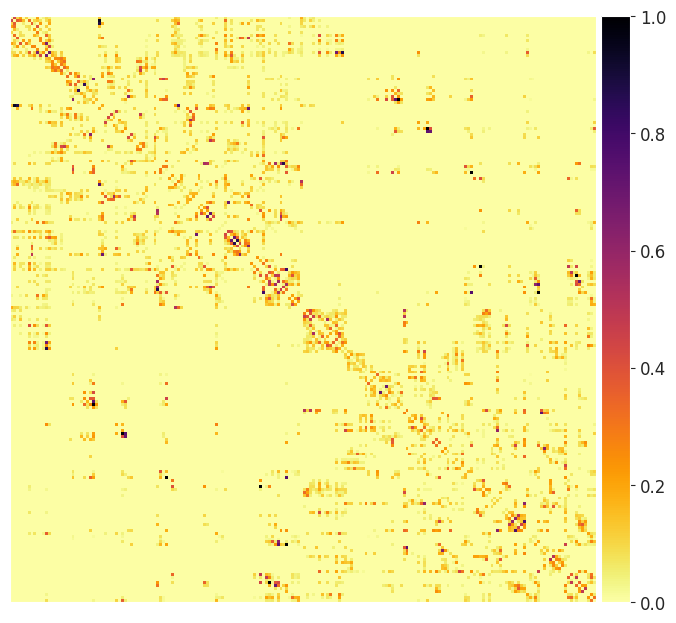

In [ ]:
figname = 'FIG_1'
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 8))
# normalize by the max value the SC matrix
C = C / np.max(C)
# Plot the connectivity matrix
disp = plotting.plot_matrix(C, colorbar=True, cmap='inferno_r', axes=ax)

# Adjust the colorbar position
cbar = disp.colorbar
cbar.ax.yaxis.set_ticks_position('right')  # Move ticks to the right
cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust tick label size

# Remove ticks from the matrix plot
disp.axes.set_xticks([])
disp.axes.set_yticks([])

# Save the figure as SVG and PNG
fig.savefig(figfold + figname + '_A1.svg', dpi=300, bbox_inches='tight')
fig.savefig(figfold + figname + '_A1.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(10,10))
# Plot connectome on brain surface
plotting.plot_connectome(C, coords, axes=ax,
                         node_size=150, edge_threshold="98%",
                         edge_cmap='inferno_r', display_mode='z',annotate=False,alpha=0.9)

plt.show()
plt.tight_layout()
fig.savefig(figfold + figname + '_A2.svg', dpi=300)
fig.savefig(figfold + figname + '_A2.png', dpi=300)

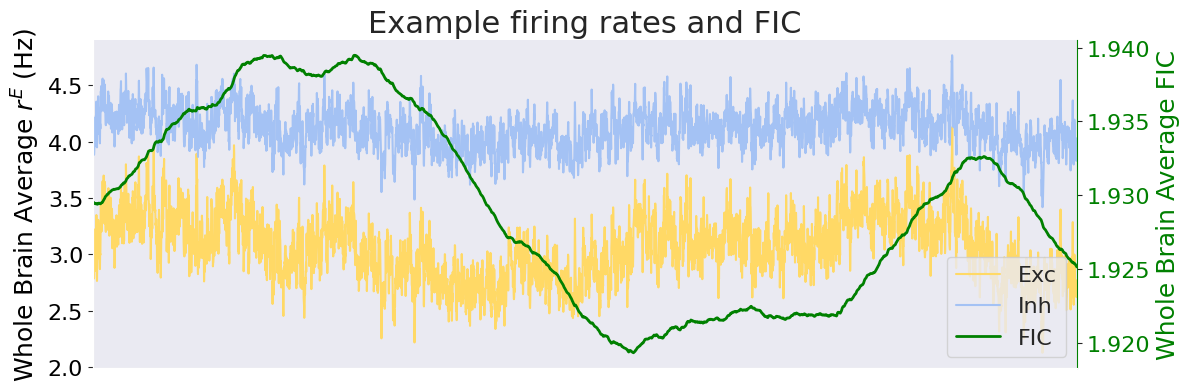

In [ ]:
sns.set_style("dark")

# Font sizes
TITLE = 22
LABEL = 18
TICKS = 16
LEGEND = 16


rates = np.load('/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/example_rates.npy')
rates_inh = np.load( '/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/example_rates_inh.npy')
fic_t = np.load( '/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/example_fic_t.npy')


# Example data (replace these with your actual data)
acor_tbase = np.arange(5000)#np.arange(rates.shape[1])  # x-axis data
max_t = len(acor_tbase)

# Create the figure and primary axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot 'rates' data on the primary y-axis
ax.plot(acor_tbase, np.mean(rates[:,:max_t], axis=0), color='#ffd966ff', label='Exc')
ax.plot(acor_tbase, np.mean(rates_inh[:,:max_t], axis=0), color='#a4c2f4ff', label='Inh')

# Labels and title for the primary axis
ax.set_ylabel('Whole Brain Average $r^E$ (Hz)', color='black', fontsize=LABEL)
ax.set_title('Example firing rates and FIC', fontsize=TITLE)
ax.tick_params(axis='y', labelcolor='black', labelsize=TICKS)
ax.set_xlim([0, max_t])

# Create a twin axis sharing the same x-axis for 'fic_t'
ax2 = ax.twinx()
ax2.plot(acor_tbase, np.mean(fic_t[:,:max_t], axis=0), color='green', linewidth=2, label='FIC')

# Labels for the secondary axis
ax2.set_ylabel('Whole Brain Average FIC', color='green', fontsize=LABEL)
ax2.tick_params(axis='y', labelcolor='green', labelsize=TICKS)
ax2.spines['right'].set_color('green')

# Customize spines for a cleaner look
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Optionally hide x-axis labels and ticks
ax.set_xticklabels([])
ax.set_xlabel('')  # Comment this line if you want the x-axis label

# Add legends for both axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right', fontsize=LEGEND)

# Layout and save
plt.tight_layout()
#fig.savefig(figfold + figname + '_A.svg', dpi=300)
#fig.savefig(figfold + figname + '_A.png', dpi=300)
plt.show()


# Fig 2 - Homeostatic Fit

In [12]:
# HOMEOSTATIC FIT
# Extracting averages over the range of G


# Homeostatic fit
hom_fit_list = [] # 0=1.22, 1=3.44, 2=6.88, 3=50
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit1-22-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit3-44-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit6-88-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit50-Grid/hom_grid.npy'))


G_range = np.arange(0,8.5, 0.5)
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
obj_rates = [1.22, 3.44, 6.88, 50]

nobjs = len(obj_rates)
ngs = len(G_range)
nlr = len(LR_range)
ndec = len(DECAY_range)
lr_labels = [1, 10, 100, 1000]
dec_labels = [100, 1000, 10000, 100000]

# Mean and average over G
mean_hom_fit = [np.mean(x,axis=2) for x in hom_fit_list]
std_hom_fit = [np.std(x,axis=2) for x in hom_fit_list]

# Extracting Minimum mismatch
min_mm_pos = [np.argmin(np.abs(x),axis=0) for x in mean_hom_fit]

# Fitting linear trend
fit_res = list()
fit_res_2plot = list()
for o in range(nobjs):
    if o==0:
        fit_res.append(np.polyfit(LR_range[21:], min_mm_pos[o][21:], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr)[21:], min_mm_pos[o][21:], 1))
    else:
        fit_res.append(np.polyfit(LR_range, min_mm_pos[o], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr), min_mm_pos[o], 1))    
    


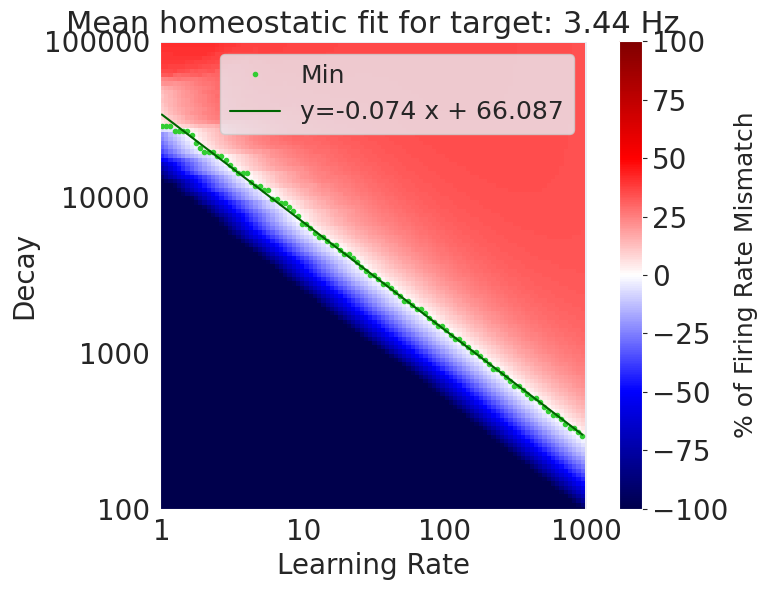

In [13]:

# Font sizes
TITLE = 22
LABEL = 20
TICKS = 20
LEGEND = 18
COLORBAR = 18

# Plotting Average over G
figname = 'FIG_2_A'
fig = plt.figure(figsize=(8, 6))

o = 1
plt.imshow(100 * mean_hom_fit[o] / obj_rates[o], vmin=-100, vmax=100, cmap='seismic', 
            origin='lower', interpolation='none')
plt.plot(range(0, nlr), min_mm_pos[o], '.', label='Min', color='limegreen')
plt.plot(range(0, nlr), fit_res_2plot[o][0] * range(0, nlr) + fit_res_2plot[o][1], '-', 
            color='darkgreen',
            label='y=' + "{:.3f}".format(fit_res[o][0]) + ' x + ' + "{:.3f}".format(fit_res[o][1]))        

plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
plt.xlabel('Learning Rate', fontsize=LABEL)
plt.title('Mean homeostatic fit for target: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
plt.ylim([0, ndec])
plt.legend(fontsize=LEGEND)

plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)   
plt.ylabel('Decay', fontsize=LABEL)


plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar

# Colorbar
#cbar_ax = fig.add_axes([0.92, 0.31, 0.02, 0.38])  # Adjust position and size of the colorbar
#cbar = plt.colorbar(cax=cbar_ax)
cbar = plt.colorbar()
cbar.set_label('% of Firing Rate Mismatch', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)  # Colorbar ticks fontsize

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')
fig.savefig(figfold + figname + '.svg', dpi=300, bbox_inches='tight')


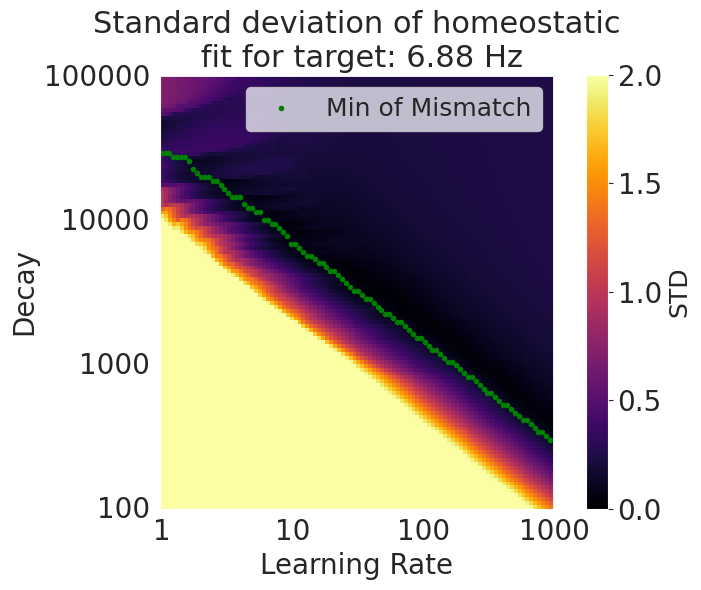

In [ ]:
# Plotting Average over G
figname = 'FIG_2_B'
fig = plt.figure(figsize=(8, 6))
o = 1
# STD over G
im = plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower', interpolation='none')
plt.plot(range(0, nlr), min_mm_pos[o], 'g.', label='Min of Mismatch')

plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
plt.xlabel('Learning Rate', fontsize=LABEL)
plt.title('Standard deviation of homeostatic\n fit for target: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)


plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)
plt.ylabel('Decay', fontsize=LABEL)

plt.legend(fontsize=LEGEND)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar

# Colorbar
#cbar_ax2 = fig.add_axes([0.92, 0.31, 0.02, 0.38])  # Adjust position and size of the colorbar
#cbar2 = plt.colorbar(im, cax=cbar_ax2)
cbar2 = plt.colorbar()
cbar2.set_label('STD', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)  # Adjust colorbar tick font size

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')
fig.savefig(figfold + figname + '.svg', dpi=300, bbox_inches='tight')


In [18]:
import matplotlib.pyplot as plt
import numpy as np

LABEL = 18
LEGEND =18
TICKS= 20
TITLE = 24

sns.set_style("darkgrid")

# Define the data path
data_path = "/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar"

# Load the results from the specified directory
dyn_fic_reps = np.load(os.path.join(data_path, "dyn_fic_reps.npy"))
stat_fic_reps = np.load(os.path.join(data_path, "stat_fic_reps.npy"))
stat_fic_reps = stat_fic_reps.reshape((dyn_fic_reps.shape), order='F').astype(np.float32)

avg_fr_dyn_values = np.load(os.path.join(data_path, "avg_fr_dyn_reps.npy"))
avg_fr_stat_values = np.load(os.path.join(data_path, "avg_fr_stat_reps.npy"))
avg_fr_mixed_values = np.load(os.path.join(data_path, "avg_fr_mix_reps.npy"))
G_values = np.load(os.path.join(data_path, "G_values.npy"))

In [29]:
G_values.shape

(49,)

In [24]:
from scipy.stats import pearsonr
# Calculate the correlation between the repetitions of dynamic and static FIC
corr_values = np.zeros((len(G_values),dyn_fic_reps.shape[1]))
for i in range(len(G_values)):
    for j in range(dyn_fic_reps.shape[1]):
        corr_values[i,j] = pearsonr(dyn_fic_reps[i, j, :], stat_fic_reps[i, j, :])[0]
# Calculate the mean and standard deviation of the correlation values
mean_corr_values = np.mean(corr_values, axis=1)
std_corr_values = np.std(corr_values, axis=1)
# Calcualte the MSE between the repetitions of dynamic and static FIC
mse_values = np.zeros((len(G_values),dyn_fic_reps.shape[1]))
for i in range(len(G_values)):
    for j in range(dyn_fic_reps.shape[1]):
        mse_values[i,j] = np.mean((dyn_fic_reps[i, j, :] - stat_fic_reps[i, j, :])**2)
# Calculate the mean and standard deviation of the MSE values
mean_mse_values = np.mean(mse_values, axis=1)
std_mse_values = np.std(mse_values, axis=1)

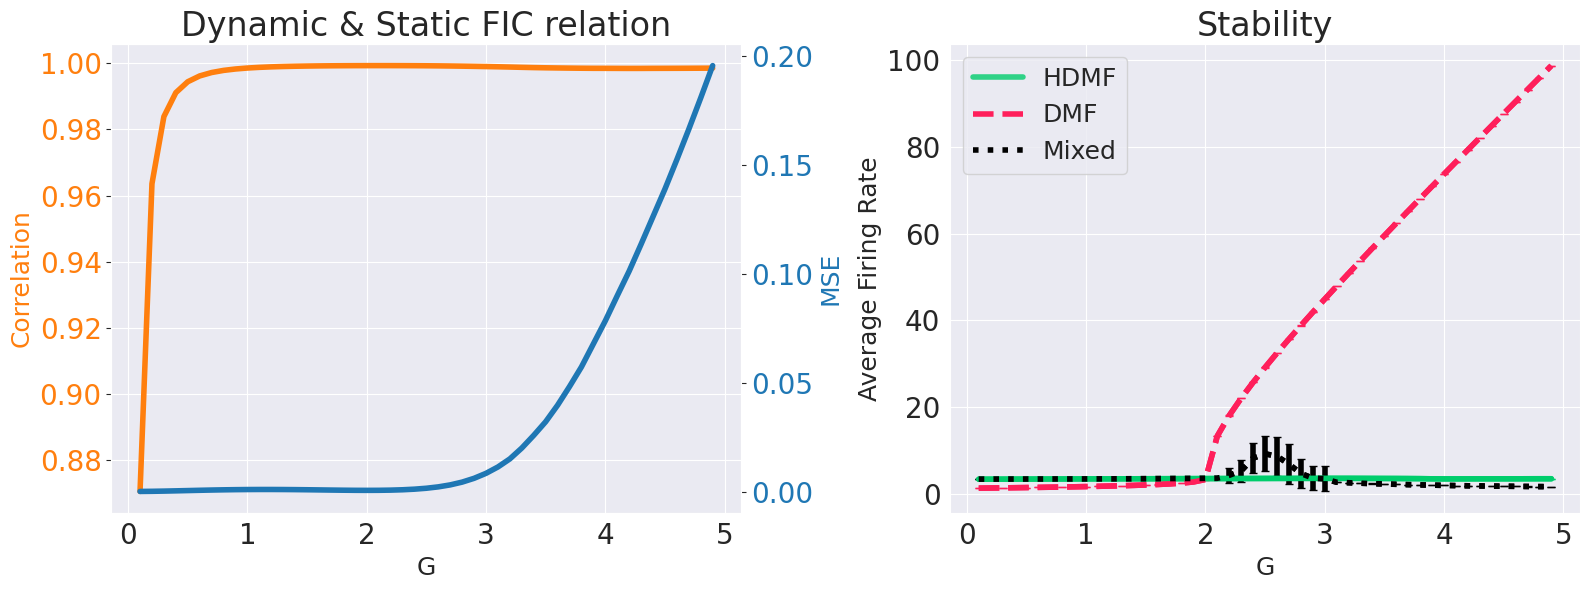

In [25]:


# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
with sns.axes_style("darkgrid"):
    # Subplot 1: Shared y-axis plot for Correlation and MSE
    ax1 = axes[0]
    color = 'tab:orange'
    ax1.set_xlabel('G', fontsize=LABEL)
    ax1.set_ylabel('Correlation', color=color, fontsize=LABEL)
    ax1.plot(G_values, mean_corr_values, color=color, label='Correlation', linewidth=4)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=TICKS)
    ax1.tick_params(axis='x', labelsize=TICKS)
with sns.axes_style("dark"):
    # MSE (Right y-axis)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('MSE', color=color, fontsize=LABEL)
    ax2.plot(G_values, mean_mse_values, color=color, label='MSE',linewidth=4)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=TICKS)

ax1.set_title('Dynamic & Static FIC relation', fontsize=TITLE)
with sns.axes_style("darkgrid"):
    # Subplot 2: Stability plot
    ax3 = axes[1]

    # Dynamic FIC: plot mean with shaded standard deviation
    mean_dyn = np.mean(avg_fr_dyn_values, axis=1)
    std_dyn = np.std(avg_fr_dyn_values, axis=1)       
    # Then plot the mean (thicker, with a legend entry)
    ax3.plot(G_values,
            mean_dyn,
            '-',
            color=category_colors['Dynamic'],
            linewidth=4,
            alpha=0.8,
            label='HDMF')
    ax3.errorbar(
        G_values,
        mean_dyn,
        yerr=std_dyn,
        fmt='-',
        color=category_colors['Dynamic'],
        linewidth=4,
        capsize=3,
        label='_nolegend_',
    )


    # Static FIC: plot mean with shaded standard deviation (dashed line)
    mean_stat = np.mean(avg_fr_stat_values, axis=1)
    std_stat = np.std(avg_fr_stat_values, axis=1)
    # Then plot the mean (thicker, with a legend entry)
    ax3.plot(G_values,
            mean_stat,
            '--',
            color=category_colors['Static'],
            linewidth=4,
            label='DMF')
    ax3.errorbar(
        G_values,
        mean_stat,
        yerr=std_stat,
        fmt='--',
        color=category_colors['Static'],
        linewidth=4,
        capsize=3,
        label='_nolegend_',
    )

    # Mixed values: plot each repetition with shaded error

    mix_rep = np.mean(avg_fr_mixed_values, axis=1)
    mix_std = np.std(avg_fr_mixed_values, axis=1)    

    ax3.plot(G_values,
            mix_rep,
            ':',
            color='black',
            linewidth=4,
            label='Mixed')
    ax3.errorbar(
            G_values,
            mix_rep,
            yerr=mix_std,
            fmt=':',
            color='black',
            linewidth=4,
            capsize=3,
            label='_nolegend_',
        )

    ax3.set_xlabel('G', fontsize=LABEL)
    ax3.set_ylabel('Average Firing Rate', fontsize=LABEL)
    ax3.tick_params(axis='x', labelsize=TICKS)
    ax3.tick_params(axis='y', labelsize=TICKS)
    ax3.set_title('Stability', fontsize=TITLE)
    handles, labels = ax3.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax3.legend(unique.values(), unique.keys(), fontsize=LEGEND)


# Adjust layout and save the figure
plt.tight_layout()
fig.savefig(figfold + 'FIG_2_C_D_combined.png', dpi=300)
fig.savefig(figfold + 'FIG_2_C_D_combined.svg', dpi=300)
plt.show()


# Supplementary Figure 1 - Other target rates

In [ ]:


# HOMEOSTATIC FIT
# Extracting averages over the range of G
G_range = np.arange(0,8.5, 0.5)
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
obj_rates = [1.22, 6.88, 50]

nobjs = len(obj_rates)
ngs = len(G_range)
nlr = len(LR_range)
ndec = len(DECAY_range)
lr_labels = [1, 10, 100, 1000]
dec_labels = [100, 1000, 10000, 100000]

# Mean and average over G
mean_hom_fit = [np.mean(x,axis=2) for x in hom_fit_list]
std_hom_fit = [np.std(x,axis=2) for x in hom_fit_list]

# Extracting Minimum mismatch
min_mm_pos = [np.argmin(np.abs(x),axis=0) for x in mean_hom_fit]

# Fitting linear trend
fit_res = list()
fit_res_2plot = list()
for o in range(nobjs):
    if o==0:
        fit_res.append(np.polyfit(LR_range[21:], min_mm_pos[o][21:], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr)[21:], min_mm_pos[o][21:], 1))
    else:
        fit_res.append(np.polyfit(LR_range, min_mm_pos[o], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr), min_mm_pos[o], 1))    
    


# Plotting Average over G
figname = 'SUPP_FIG_1_A'
fig = plt.figure(figsize=(16, 10))

for o in range(nobjs):
    # Average over G
    ax = plt.subplot(1, nobjs, o + 1)
    plt.imshow(100 * mean_hom_fit[o] / obj_rates[o], vmin=-100, vmax=100, cmap='seismic', 
               origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], '.', label='Min', color='limegreen')
    plt.plot(range(0, nlr), fit_res_2plot[o][0] * range(0, nlr) + fit_res_2plot[o][1], '-', 
             color='darkgreen',
             label='y=' + "{:.3f}".format(fit_res[o][0]) + ' x + ' + "{:.3f}".format(fit_res[o][1]))        
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    plt.ylim([0, ndec])
    plt.legend(fontsize=LEGEND)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)   
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.31, 0.02, 0.38])  # Adjust position and size of the colorbar
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('% of Firing Rate Mismatch', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)  # Colorbar ticks fontsize

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')
fig.savefig(figfold + figname + '.svg', dpi=300, bbox_inches='tight')

In [ ]:


# Plotting STD
figname = 'SUPP_FIG_1_B'
fig = plt.figure(figsize=(16, 10))
for o in range(nobjs):
    # STD over G
    ax = plt.subplot(1, nobjs, o + 1)
    im = plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], 'g.', label='Min of Mismatch')
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])

plt.legend(fontsize=LEGEND)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar

# Colorbar
cbar_ax2 = fig.add_axes([0.92, 0.31, 0.02, 0.38])  # Adjust position and size of the colorbar
cbar2 = plt.colorbar(im, cax=cbar_ax2)
cbar2.set_label('STD', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)  # Adjust colorbar tick font size

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')
fig.savefig(figfold + figname + '.svg', dpi=300, bbox_inches='tight')


# Fig 3 - Fitting resting state

In [37]:
import fastdyn_fic_dmf as dmf

def compute_fcd(data, wsize, overlap, isubdiag, params):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0], isubdiag[1]]
    return fcd

C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2 * C / np.max(C)
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
isubfcd = np.triu_indices(C.shape[1], 1)
burnout = 7
params["wsize"] = 30
overlap = 29
params['TR'] = 2
T = 250
params['dtt'] = 0.001  # Assuming 'dtt' is defined; adjust as needed
nb_steps = int(T * params['TR'] / params['dtt'])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

emp_data = mat73.loadmat('data/BOLD_timeseries_Awake.mat')
emp_data = np.squeeze(np.array(emp_data['BOLD_timeseries_Awake']))[:,:200,:]
emp_data = emp_data[:,:,burnout:]


emp_fcds = []
for sub in range(emp_data.shape[0]):
    fcds = compute_fcd(emp_data[sub, :, :].T, params["wsize"], overlap, isubfcd, params)
    upp_tr_fcd = np.corrcoef(fcds.T)[np.triu_indices(nwins-1, 1)]
    emp_fcds.append(upp_tr_fcd)

emp_fc = np.mean(np.array([np.corrcoef(emp_data[sub, :, :]) for sub in range(emp_data.shape[0])]), axis=0)
# remove the diagonal
emp_fc = emp_fc - np.eye(emp_fc.shape[0])

emp_fcd = np.hstack((emp_fcds))

In [38]:
# load ~/Desktop/DatosParaRuben/FittedSimulations/fcs_grid.npy

fcs_grid = np.load('/home/ivan.mindlin/Desktop/DatosParaRuben/FittedSimulations_TR2/fcs_grid.npy')
fcds_grid = np.load('/home/ivan.mindlin/Desktop/DatosParaRuben/FittedSimulations_TR2/fcds_grid.npy')

In [43]:
fcds_grid.shape

(2, 100, 212, 212)

In [39]:
# ------------------------------------------------------------------
# PRE‑COMPUTED GRIDS
#   fcs_grid  : (2, nRep, N, N)
#   fcds_grid : (2, nRep, nWins, nWins)        # square, NOT flattened
# ------------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

triu_fc  = np.triu_indices(fcs_grid.shape[2], k=1)
n_rep    = fcs_grid.shape[1]

rep_corr = np.zeros((2, n_rep))
mean_mse_values = np.zeros((2, n_rep))  # MSE values for each repetition
rep_ks   = np.zeros((2, n_rep))

sim_fcd_stat_vals = []        # 1‑D vectors collected here
sim_fcd_dyn_vals  = []

for m, label in enumerate(("Static", "Dynamic")):          # m = 0/1
    for r in range(n_rep):
        # ---------- FC correlation ----------
        sim_fc      = fcs_grid[m, r]
        rep_corr[m, r] = pearsonr(sim_fc[triu_fc], emp_fc[triu_fc])[0]
        # ---------- MSE ----------
        sim_fc_mat  = fcs_grid[m, r]          # square (N × N)
        sim_fc_vals = sim_fc_mat[triu_fc]
        emp_fc_vals = emp_fc[triu_fc]
        # Two‑sample MSE against the empirical pool
        mean_mse = np.mean((sim_fc_vals - emp_fc_vals) ** 2)
        mean_mse_values[m, r] = mean_mse

        # ---------- FCD distribution ----------
        sim_fcd_mat = fcds_grid[m, r]          # square (nWins × nWins)
        triu_FCD    = np.triu_indices(sim_fcd_mat.shape[0]-1, k=1)
        sim_fcd_vals = sim_fcd_mat[triu_FCD]

        # Two‑sample KS distance against the empirical pool
        rep_ks[m, r] = ks_2samp(sim_fcd_vals, emp_fcd)[0]

        # Collect for the histogram (ONE flat vector!)
        if m == 0:
            sim_fcd_stat_vals.append(sim_fcd_vals)
        else:
            sim_fcd_dyn_vals.append(sim_fcd_vals)

# concatenate across repetitions so seaborn sees three 1‑D vectors
sim_fcd_stat = np.hstack(sim_fcd_stat_vals)
sim_fcd_dyn  = np.hstack(sim_fcd_dyn_vals)

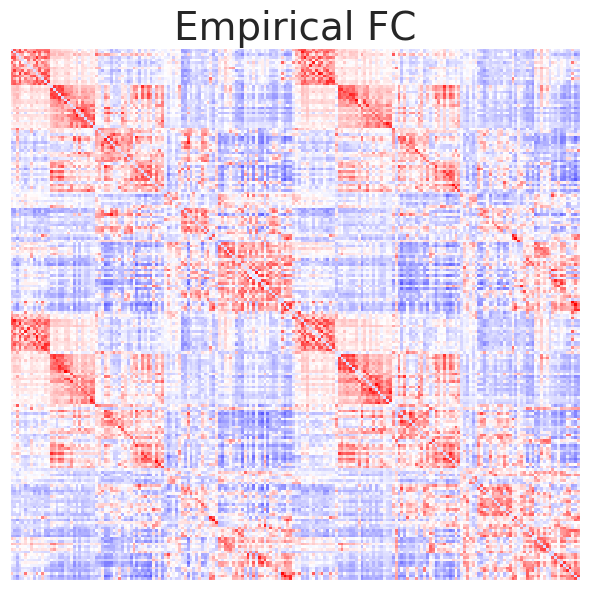

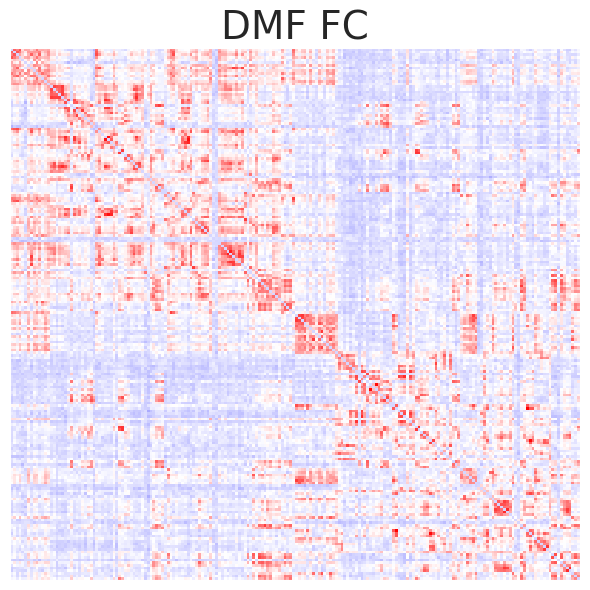

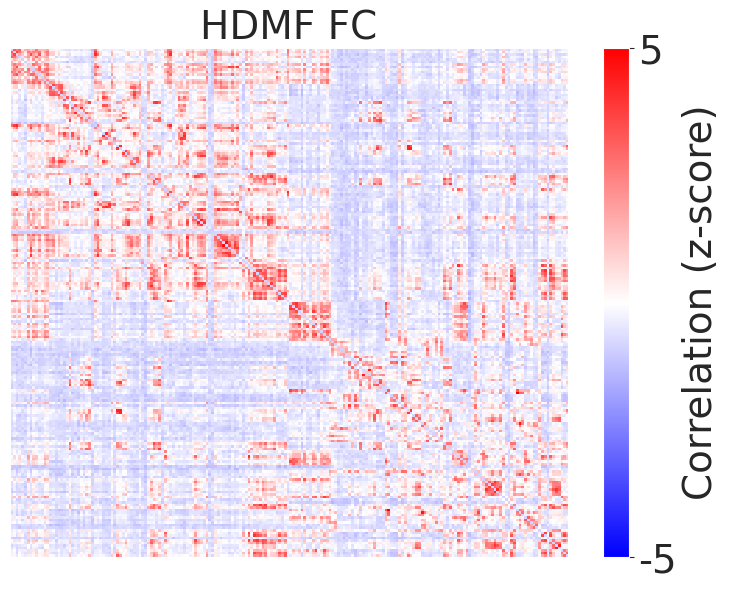

In [40]:
	
# Font sizes
from tkinter import font


TITLE = 28
LABEL = 18
TICKS = 18
COLORBAR = 18
LEGEND = 18


# Parameters
figname_base = 'FIG_3_'

fc_color_palette = 'bwr' #sns.diverging_palette(145, 300, s=60, as_cmap=True)
# Plot A: Empirical FC
fig_a = plt.figure(figsize=(6, 6))
# put 0 on the diagonal

# z-score the fc excluding the diagonal
emp_fc = (emp_fc - np.mean(emp_fc[triu_fc])) / np.std(emp_fc[triu_fc])
lim= np.max(np.abs(emp_fc))
plt.imshow(emp_fc, interpolation='none', aspect='auto', cmap=fc_color_palette, vmin=-lim, vmax=lim)


plt.title('Empirical FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
fig_a.savefig(figfold + figname_base + 'A.png', dpi=300)
fig_a.savefig(figfold + figname_base + 'A.svg', dpi=300)
plt.show()

# Plot B: DMF FC
fig_b = plt.figure(figsize=(6, 6))
ave_static_fc = np.mean(fcs_grid[0, :16, :, :], axis=0)
# remove the diagonal
ave_static_fc = ave_static_fc - np.eye(ave_static_fc.shape[0])
# z-score the fc excluding the diagonal
ave_static_fc = (ave_static_fc - np.mean(ave_static_fc[triu_fc])) / np.std(ave_static_fc[triu_fc])
lim = np.max(np.abs(ave_static_fc))
plt.imshow(ave_static_fc, interpolation='none', aspect='auto', cmap=fc_color_palette, vmin=-lim, vmax=lim)
plt.title('DMF FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
fig_b.savefig(figfold + figname_base + 'B.png', dpi=300)
fig_b.savefig(figfold + figname_base + 'B.svg', dpi=300)
plt.show()

# Plot C: HDMF FC
fig_c = plt.figure(figsize=(7.55, 6))
ave_dynamic_fc = np.mean(fcs_grid[1, :16, :, :], axis=0)
ave_dynamic_fc = ave_dynamic_fc - np.eye(ave_dynamic_fc.shape[0]) 
# z-score the fc excluding the diagonal
ave_dynamic_fc = (ave_dynamic_fc - np.mean(ave_dynamic_fc[triu_fc])) / np.std(ave_dynamic_fc[triu_fc])
lim = np.max(np.abs(ave_dynamic_fc))
h = plt.imshow(ave_dynamic_fc, interpolation='none', aspect='auto', cmap=fc_color_palette, vmin=-lim, vmax=lim)
cbar = plt.colorbar(h)
# Put -1 and 1 in the colorbar
cbar.set_ticks([-lim, lim])
cbar.set_ticklabels(['-5', '5'], fontsize=TITLE)
cbar.set_label('Correlation (z-score)', fontsize=TITLE)
plt.title('HDMF FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
#fig_c.savefig(figfold + figname_base + 'C.png', dpi=300)
#fig_c.savefig(figfold + figname_base + 'C.svg', dpi=300)
plt.show()

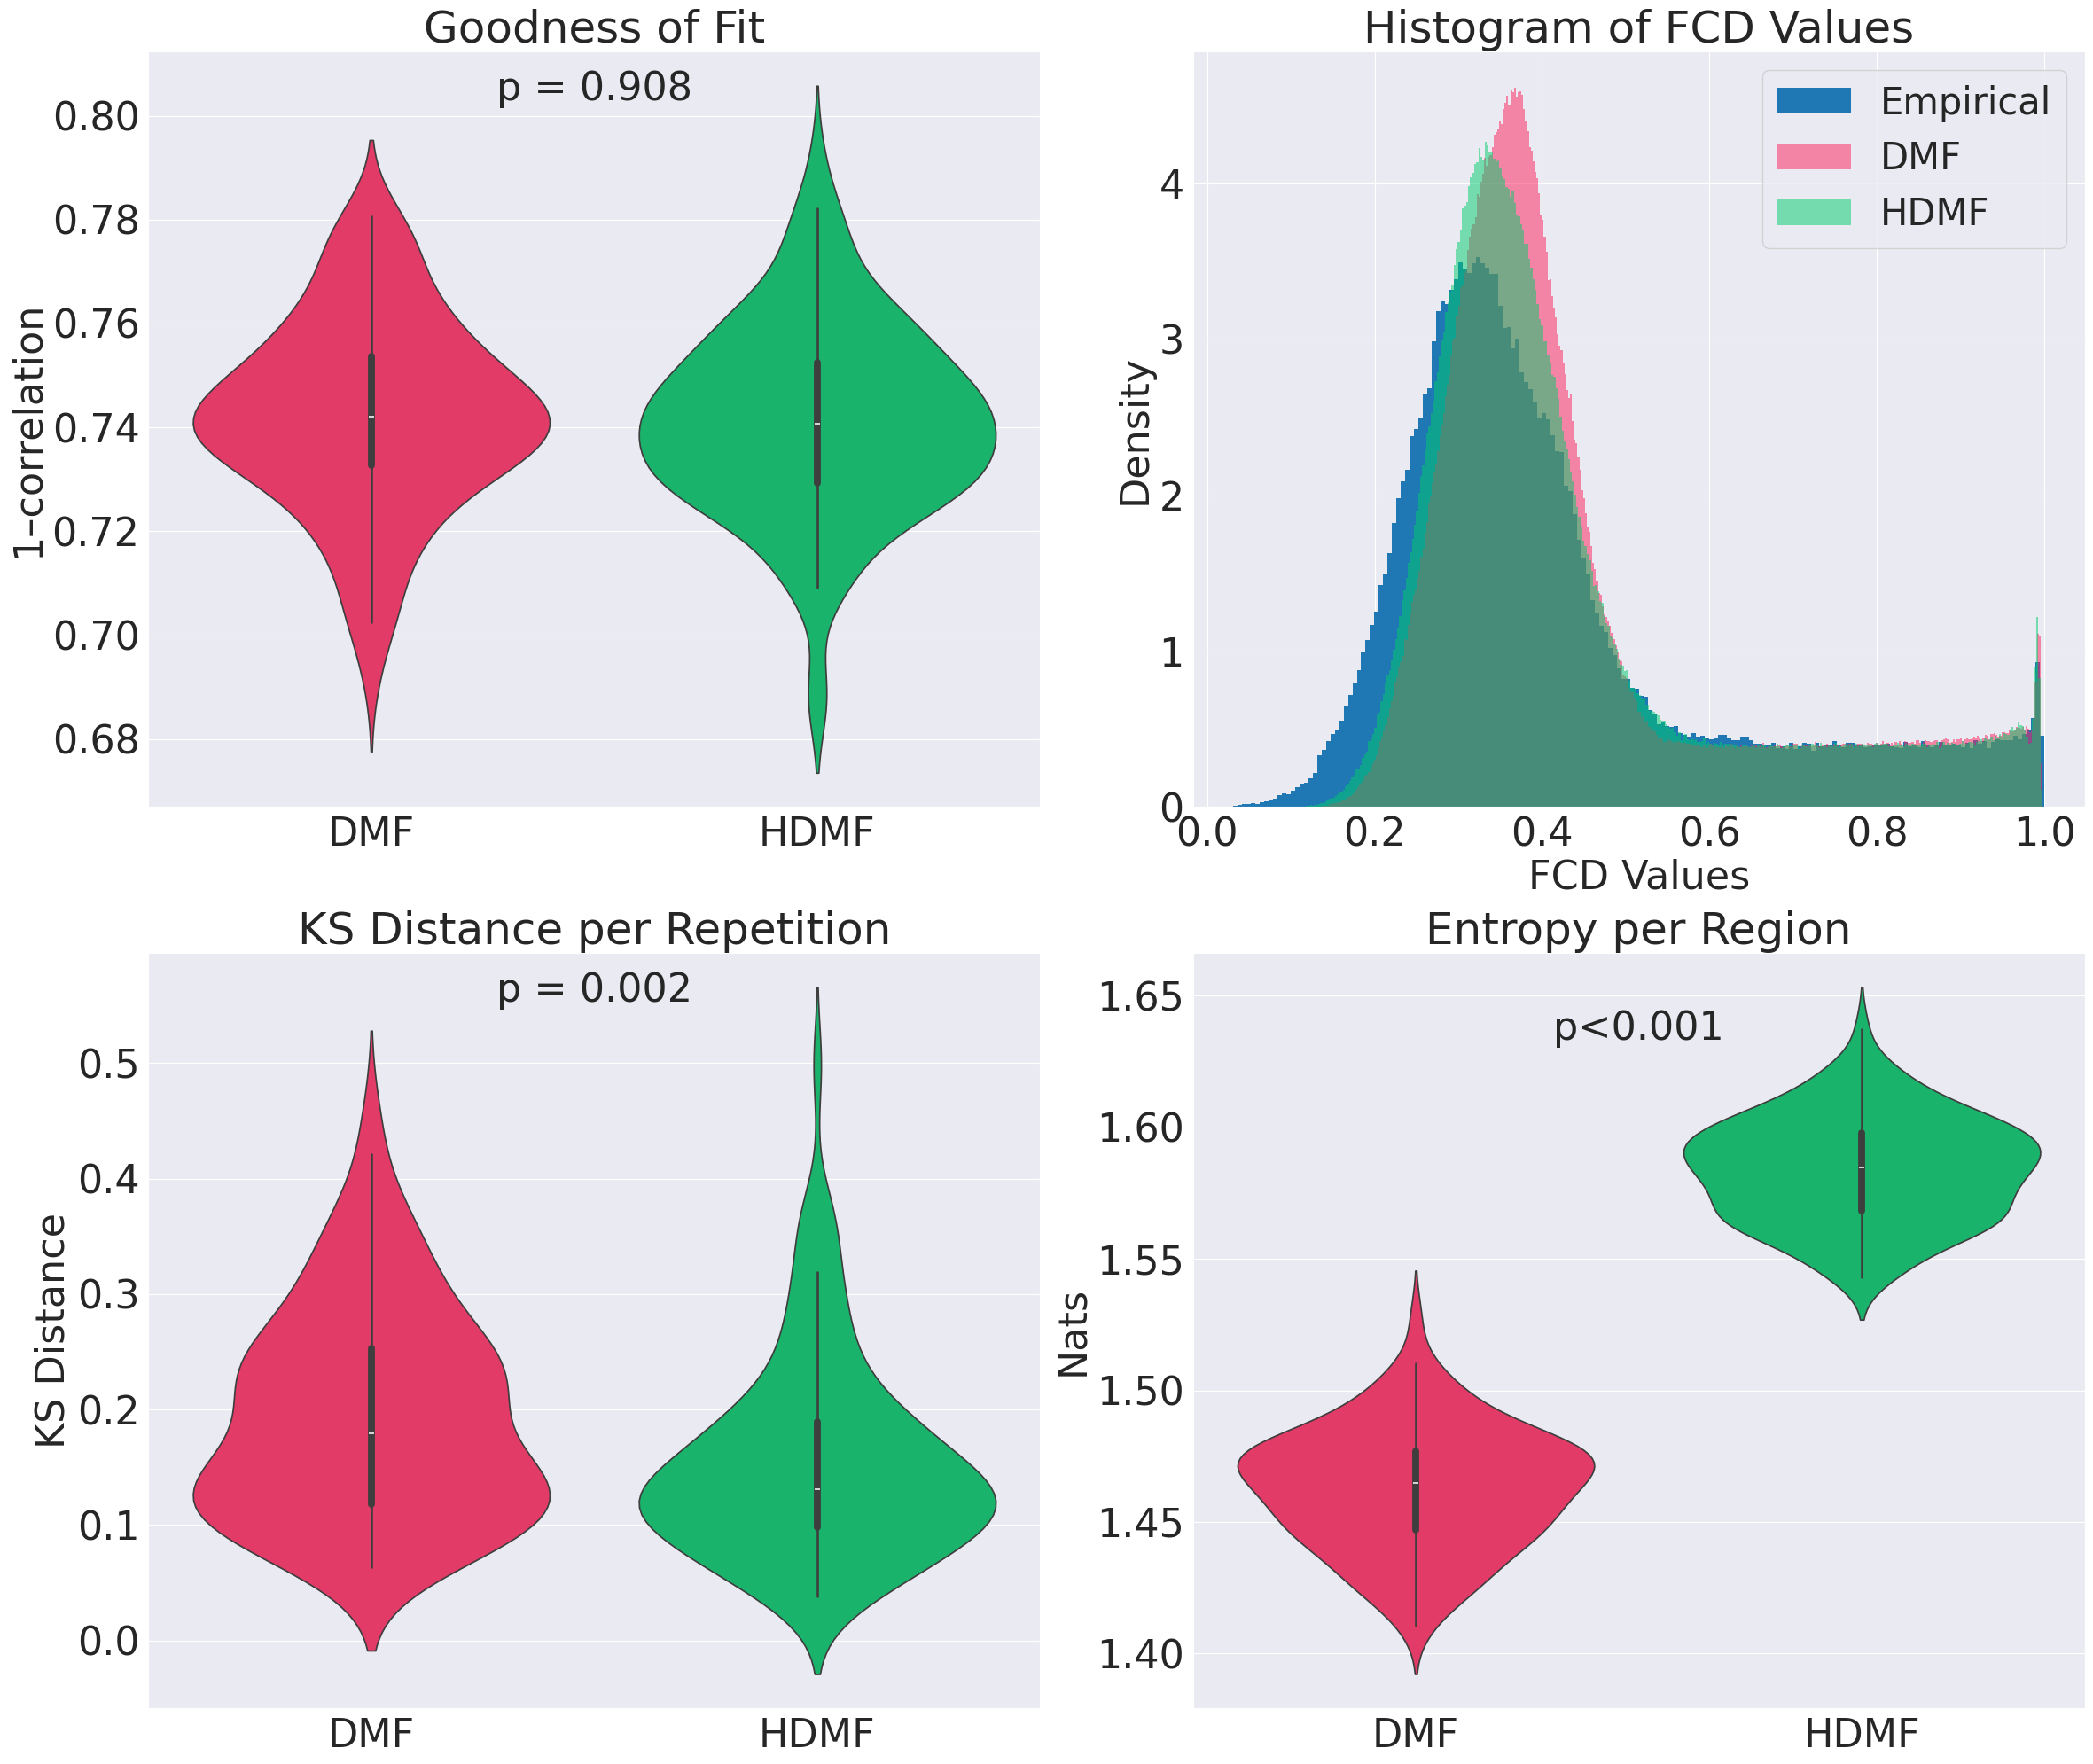

In [ ]:
from curses import color_pair
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import numpy as np

# Font sizes
TITLE = 36
LABEL = 32
TICKS = 32
LEGEND = 30

sns.set_style("darkgrid")
static_color = category_colors['Static']
dynamic_color = category_colors['Dynamic']

# Compute goodness‐of‐fit
gof = 1 - rep_corr.T  # shape=(repetitions,2)

# Make 2×2 axes
fig, axes = plt.subplots(2, 2, figsize=(24, 20))
ax00, ax01 = axes[0]
ax10, ax11 = axes[1]

# (0,0) Goodness‐of‐Fit Violin
sns.violinplot(data=gof, palette=[static_color, dynamic_color], ax=ax00)
ax00.set_xticks([0, 1])
ax00.set_xticklabels(['DMF', 'HDMF'], fontsize=TICKS)
ax00.set_ylabel('1–correlation', fontsize=LABEL)
# set the size of the y-ticks
ax00.tick_params(labelsize=TICKS)
ax00.set_title('Goodness of Fit', fontsize=TITLE)
stat_d, p_d = ks_2samp(gof[:, 0], gof[:, 1])
if p_d < 0.001:
    ann = '***'
elif p_d < 0.01:
    ann = '**'
elif p_d < 0.05:
    ann = '*'
else:
    ann = f"p = {p_d:.3f}"
ax00.text(0.5, 0.95, ann, ha='center', va='center',
          transform=ax00.transAxes, fontsize=LABEL)

col_pal = sns.color_palette("tab10", 10)
# (0,1) Histogram of FCD
sns.histplot(emp_fcd, stat='density', color=col_pal[0], alpha=1, linewidth=0, ax=ax01, label='Empirical')
sns.histplot(sim_fcd_stat, stat='density', color=static_color, alpha=0.5, linewidth=0, ax=ax01, label='DMF')
sns.histplot(sim_fcd_dyn, stat='density', color=dynamic_color, alpha=0.5, linewidth=0, ax=ax01, label='HDMF')
ax01.set_xlabel('FCD Values', fontsize=LABEL)
ax01.set_ylabel('Density', fontsize=LABEL)
ax01.set_title('Histogram of FCD Values', fontsize=TITLE)
ax01.tick_params(labelsize=TICKS)
ax01.legend(fontsize=LEGEND)

# (1,0) Violin of KS‐distances per repetition
sns.violinplot(data=rep_ks.T, palette=[static_color, dynamic_color], ax=ax10)
ax10.set_xticks([0, 1])
ax10.set_xticklabels(['DMF', 'HDMF'], fontsize=TICKS)
ax10.set_ylabel('KS Distance', fontsize=LABEL)
ax10.tick_params(labelsize=TICKS)
ax10.set_title('KS Distance per Repetition', fontsize=TITLE)
stat_k, p_k = ks_2samp(rep_ks[0], rep_ks[1])
ax10.text(0.5, 0.95, f"p = {p_k:.3f}", ha='center', va='center',
           transform=ax10.transAxes, fontsize=LABEL)

# (1,1) Entropy per region
ent_stat = np.mean(np.load(datafolder+'FittedSimulations/stat_entropy.npy'), axis=1)
ent_dyn  = np.mean(np.load(datafolder+'FittedSimulations/dyn_entropy.npy'), axis=1)
#sns.stripplot(data=[ent_stat, ent_dyn], jitter=True, color='k', alpha=0.5, ax=ax11)
sns.violinplot(data=[ent_stat, ent_dyn], palette=[static_color, dynamic_color], ax=ax11)
ax11.set_xticks([0, 1])
ax11.set_xticklabels(['DMF', 'HDMF'], fontsize=TICKS)
ax11.set_ylabel('Nats', fontsize=LABEL)
ax11.tick_params(labelsize=TICKS)
ax11.set_title('Entropy per Region', fontsize=TITLE)
_, p_e = ks_2samp(ent_stat, ent_dyn)
if p_e < 0.001:
    ax11.text(0.5, 0.9, 'p<0.001', ha='center', va='center',
               transform=ax11.transAxes, fontsize=LABEL)

plt.tight_layout()
#fig.savefig(figfold + figname_base + '2x2.png', dpi=300)
#fig.savefig(figfold + figname_base + '2x2.svg', dpi=300)
plt.show()


In [45]:
# Statistcal tests between distributions
from scipy.stats import wilcoxon
ks, p_fcd = ks_2samp(rep_ks[0,:],rep_ks[1,:])
ks_corr, p_fc = ks_2samp(rep_corr[0,:],rep_corr[1,:])

_, w_p_fcd= wilcoxon(rep_ks[0,:],rep_ks[1,:])
_, w_p_fc= wilcoxon(rep_corr[0,:],rep_corr[1,:])
[p_fcd, p_fc, w_p_fcd,w_p_fc]

# Cohen's d for FCD ks values
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import DescrStatsW
def cohen_d(x, y):
    """Calculate Cohen's d for two independent samples."""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    mean_diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return mean_diff / pooled_std
# For the FCD values
cohen_d_fcd = cohen_d(rep_ks[0,:],rep_ks[1,:])
print(f"KS test p-value for FCD: {p_fcd}, Cohen's d: {cohen_d_fcd}")
# For the entropy values
cohen_d_entropy = cohen_d(ent_stat, ent_dyn)
print(f"KS test p-value for Entropy: {p_e}, Cohen's d: {cohen_d_entropy}")

KS test p-value for FCD: 0.002219935934558366, Cohen's d: 0.46238866908509807
KS test p-value for Entropy: 2.2087606931995054e-59, Cohen's d: -5.611343385313267


### PET image

## Fig 4 - Neuromodulation

In [ ]:

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic, 2 mixed
nm_std_fr = [] 
nm_fc = [] 
nm_fcd = [] 
nm_mean_fr.append(np.load(datafolder+'neuromod/static5HT2a/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamic5HT2a/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/mixed5HT2a/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/static5HT2a/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamic5HT2a/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/mixed5HT2a/std_fr_grid.npy'))

In [ ]:
## Computing the correlation between receptor density and firing rates for each learning rate

RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]

RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
receptors = np.reshape(RECEPTORS, (RECEPTORS.shape[0],1))
nlrs = 10
polyfit_out_static = [np.polyfit(np.squeeze(receptors), nm_mean_fr[0][x].T, 1, full=True) for x in range(nlrs)]
polyfit_out_dyn = [np.polyfit(np.squeeze(receptors), nm_mean_fr[1][x].T, 1, full=True) for x in range(nlrs)]
polyfit_out_mixed = [np.polyfit(np.squeeze(receptors), nm_mean_fr[2][x].T, 1, full=True) for x in range(nlrs)]

corr_out_static = [1-cdist(receptors.T, nm_mean_fr[0][x],metric='correlation') for x in range(nlrs)]
corr_out_dyn = [1-cdist(receptors.T, nm_mean_fr[1][x],metric='correlation') for x in range(nlrs)]
corr_out_mixed = [1-cdist(receptors.T, nm_mean_fr[2][x],metric='correlation') for x in range(nlrs)]

slope_rec_fr = [np.vstack([x[0][0],y[0][0],(z[0][0])]) for x,y,z in zip(polyfit_out_static,polyfit_out_dyn,polyfit_out_mixed)]
res_rec_fr = [np.vstack([x[0][1],y[0][1],(z[0][1])]) for x,y,z in zip(polyfit_out_static,polyfit_out_dyn,polyfit_out_mixed)]
corr_rec_fr = [np.vstack([x,y,z]) for x,y,z in zip(corr_out_static,corr_out_dyn,corr_out_mixed)]



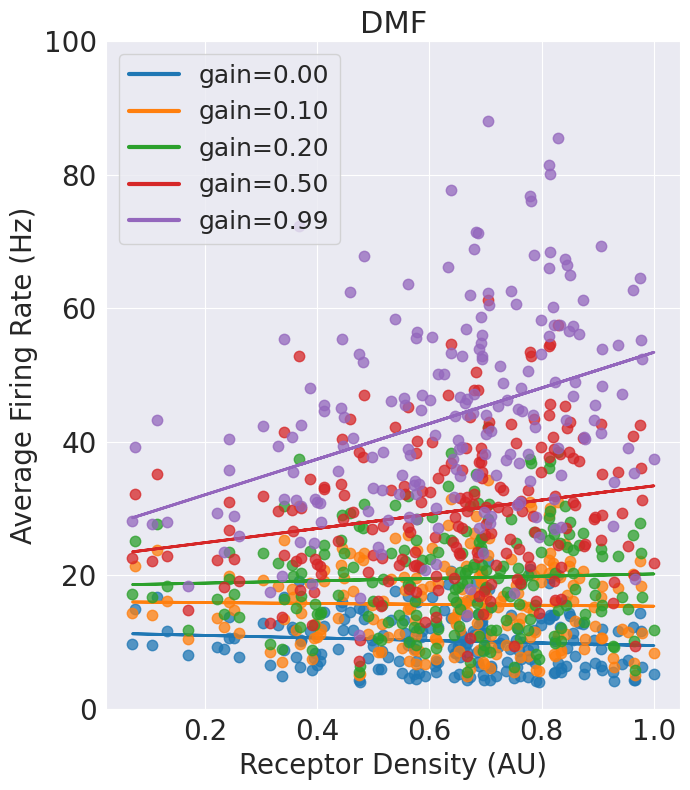

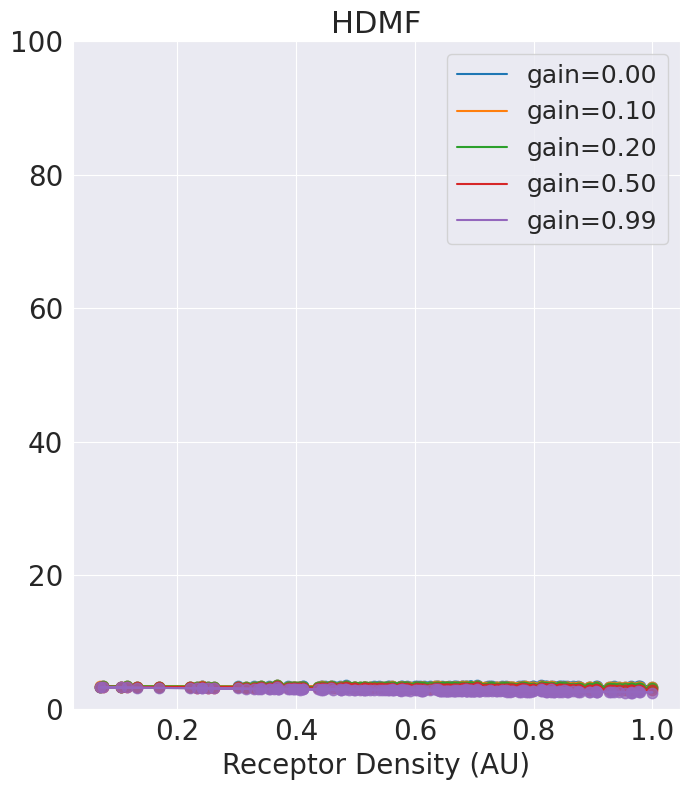

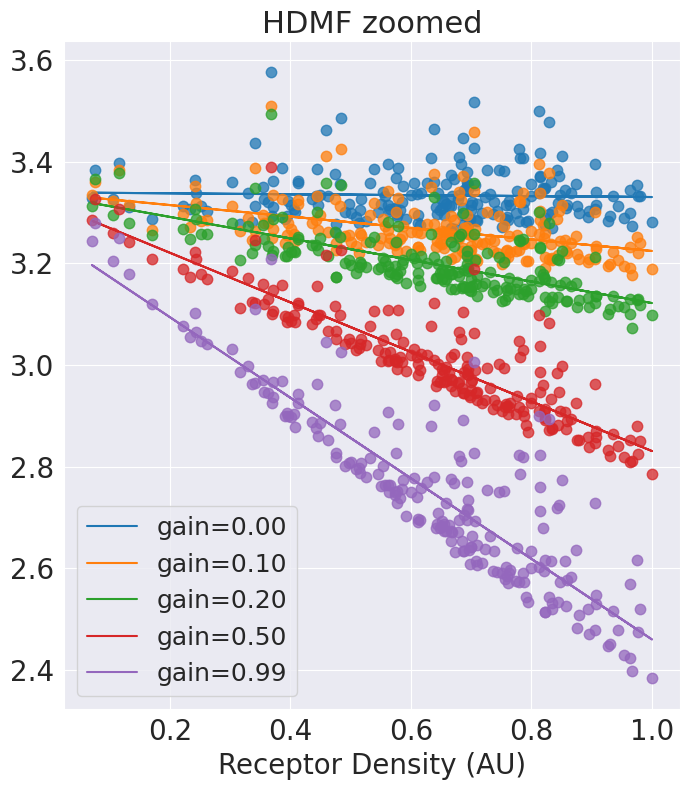

In [49]:

# Font sizes
TITLE = 22
LABEL = 20
TICKS = 20
LEGEND = 18
COLORBAR = 18
sns.set_style("darkgrid")
# Parameters
titles = ['DMF', 'HDMF','Mixed']
lr_vals = np.logspace(0, 2.46, 10)
alpha_vals = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05]
receptors = RECEPTORS
gains2plot = [0, 10, 20, 50, 99]
nm_2_plot = [6, 8,5]  # Indices for DMF, HDMF, Mixed
figname = 'FIG_4'

# Figure 1: DMF
fig1 = plt.figure(figsize=(7, 8))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors,
                     nm_mean_fr[0][nm_2_plot[0], g, :],
                     '.',
                     markersize=15,
                     alpha=0.75)
    # Compute and plot the linear fit with thicker line
    coeffs = np.polyfit(np.squeeze(receptors),
                        nm_mean_fr[0][nm_2_plot[0], g, :],
                        1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors,
             linear_fit(receptors),
             '-',
             color=plot.get_color(),
             linewidth=2,          # make line thicker
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.ylabel('Average Firing Rate (Hz)', fontsize=LABEL)
plt.title(titles[0], fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.ylim([0, 100])

# Draw legend and thicken its lines
leg = plt.legend(fontsize=LEGEND)
for legline in leg.get_lines():
    legline.set_linewidth(3)

plt.tight_layout()
plt.show()

# Save FIG_3A
fig1.savefig(figfold + figname + '_DMF.svg', dpi=300)
fig1.savefig(figfold + figname + '_DMF.png', dpi=300)



# Figure 2: HDMF
fig2 = plt.figure(figsize=(7, 8))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[1][nm_2_plot[1], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[1][nm_2_plot[1], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.title(titles[1], fontsize=TITLE)
# Put the same range for both y-axes
plt.ylim([0, 100])
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3B
fig2.savefig(figfold + figname + '_HDMF.svg', dpi=300)
fig2.savefig(figfold + figname + '_HDMF.png', dpi=300)

# Figure 2: HDMF
fig3 = plt.figure(figsize=(7, 8))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[1][nm_2_plot[1], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[1][nm_2_plot[1], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.title(titles[1] + ' zoomed', fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3B
fig3.savefig(figfold + figname + '_HDMF_zoomed.svg', dpi=300)
fig3.savefig(figfold + figname + '_HDMF_zoomed.png', dpi=300)

# Supplementary Fig 3 - Grid of neuromodulations

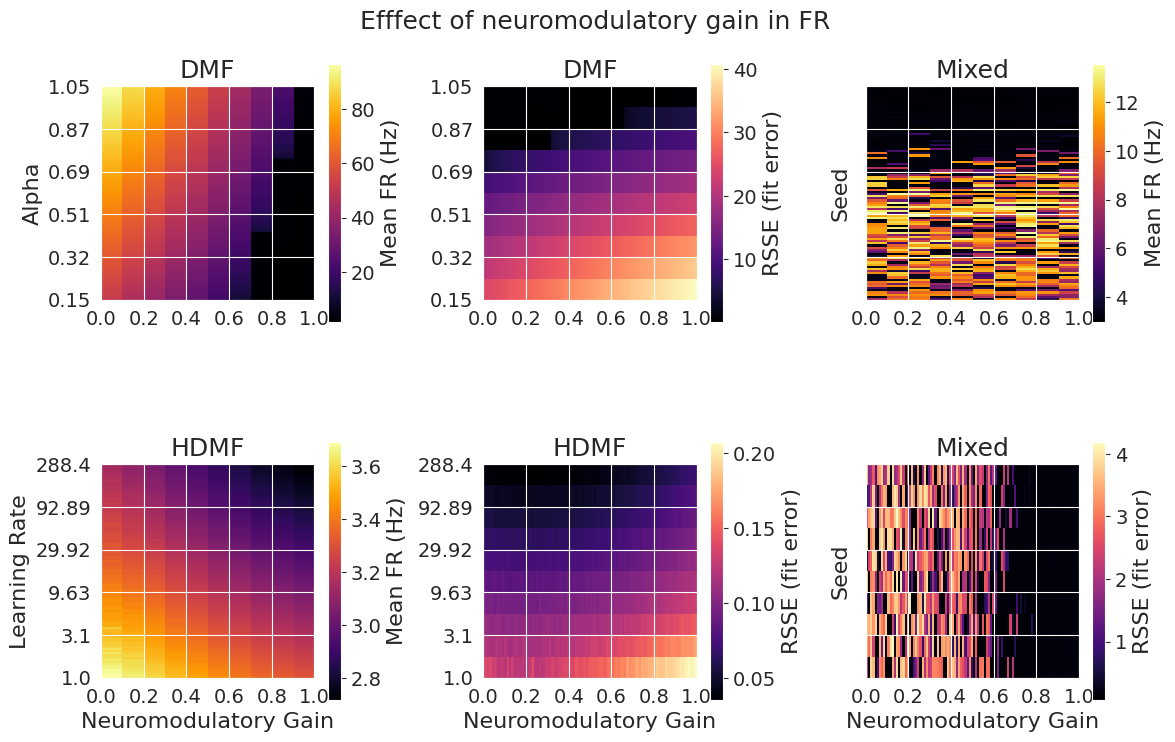

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Font sizes
TITLE = 18
LABEL = 16
TICKS = 14
COLORBAR = 16

# Parameters
figname = 'Supp_2_with_Mixed'

titles = ['DMF', 'HDMF', 'Mixed']
yticks = [
    np.floor(np.linspace(0.15, 1.05, 6) * 100) / 100,
    np.floor(np.logspace(0, 2.46, 6) * 100) / 100,
    []
]
ylabel = ['Alpha', 'Learning Rate']

sse_rec_fr = [np.vstack([s_out[1], d_out[1], m_out[1]])
               for s_out, d_out, m_out in zip(polyfit_out_static, polyfit_out_dyn, polyfit_out_mixed)]

# Build mean firing rate grids (n_LR × n_gains) and SSE error grids
mean_fr_stack = np.array([nm_mean_fr[m].mean(axis=2) for m in range(3)])  # shape (3, n_LR, n_gains)
sse_rec_fr_rs = np.dstack((sse_rec_fr))  # shape (3, n_gains, n_LR)

# 1) compute RMSE per region
n_regions = nm_mean_fr[0].shape[-1]          # e.g. 200
rmse_rec_fr = [np.sqrt(s_grid / n_regions)   # s_grid shape (3,n_LR)
               for s_grid in sse_rec_fr]     
# 2) stack into (3, n_gains, n_LR) for plotting
rmse_rec_fr_rs = np.dstack(rmse_rec_fr)

# 3) update vmin/vmax for RMSE heatmaps
sse_vmin = [arr.min() for arr in rmse_rec_fr_rs.reshape(3, -1)]
sse_vmax = [arr.max() for arr in rmse_rec_fr_rs.reshape(3, -1)]


# Set dynamic display ranges
fr_vmin = [arr.min() for arr in mean_fr_stack]
fr_vmax = [arr.max() for arr in mean_fr_stack]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# — DMF (column 0) —
ax = axes[0, 0]
im = ax.imshow(mean_fr_stack[0].T, origin='lower',
               vmin=fr_vmin[0], vmax=fr_vmax[0],
               cmap='inferno', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[0], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Mean FR (Hz)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[0], fontsize=TICKS)
ax.set_ylabel(ylabel[0], fontsize=LABEL)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)

ax = axes[0, 1]
im = ax.imshow(rmse_rec_fr_rs[0].T, origin='lower',
               vmin=sse_vmin[0], vmax=sse_vmax[0],
               cmap='magma', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[0], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('RSSE (fit error)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[0], fontsize=TICKS)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)


# — HDMF (column 1) —
ax = axes[1, 0]
im = ax.imshow(mean_fr_stack[1].T, origin='lower',
               vmin=fr_vmin[1], vmax=fr_vmax[1],
               cmap='inferno', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[1], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Mean FR (Hz)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_ylabel(ylabel[1], fontsize=LABEL)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[1], fontsize=TICKS)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)
ax.set_xlabel('Neuromodulatory Gain', fontsize=LABEL)

ax = axes[1, 1]
im = ax.imshow(rmse_rec_fr_rs[1].T, origin='lower',
               vmin=sse_vmin[1], vmax=sse_vmax[1],
               cmap='magma', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[1], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('RSSE (fit error)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[1], fontsize=TICKS)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)
ax.set_xlabel('Neuromodulatory Gain', fontsize=LABEL)

# — Mixed (column 2) —
ax = axes[0, 2]
im = ax.imshow(mean_fr_stack[2].T, origin='lower',
               vmin=fr_vmin[2], vmax=fr_vmax[2],
               cmap='inferno', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[2], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Mean FR (Hz)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[2], fontsize=TICKS)
ax.set_ylabel('Seed', fontsize=LABEL)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)

ax = axes[1, 2]
im = ax.imshow(rmse_rec_fr_rs[2].T, origin='lower',
               vmin=sse_vmin[2], vmax=sse_vmax[2],
               cmap='magma', interpolation='none',
               extent=(0, 100, 0, 100))
ax.set_title(titles[2], fontsize=TITLE)
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('RSSE (fit error)', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(yticks[2], fontsize=TICKS)
ax.set_ylabel('Seed', fontsize=LABEL)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xticklabels(np.linspace(0, 100, 6) / 100, fontsize=TICKS)
ax.set_xlabel('Neuromodulatory Gain', fontsize=LABEL)

plt.tight_layout()
fig.suptitle('Efffect of neuromodulatory gain in FR', fontsize=TITLE)
fig.savefig(figfold + figname + '_MeanSSE.svg', dpi=300)
plt.show()

# Fig 5 - Slow waves

In [59]:
e_rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_results.npy')
#rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_inh_results.npy')
fic_tseries = np.load(datafolder+'slow_waves/time_series_examples/fic_t_results.npy')
gvals_tseries = np.load(datafolder+'slow_waves/time_series_examples/G_vals.npy')


In [ ]:
from scipy.signal import find_peaks, correlate,welch


def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

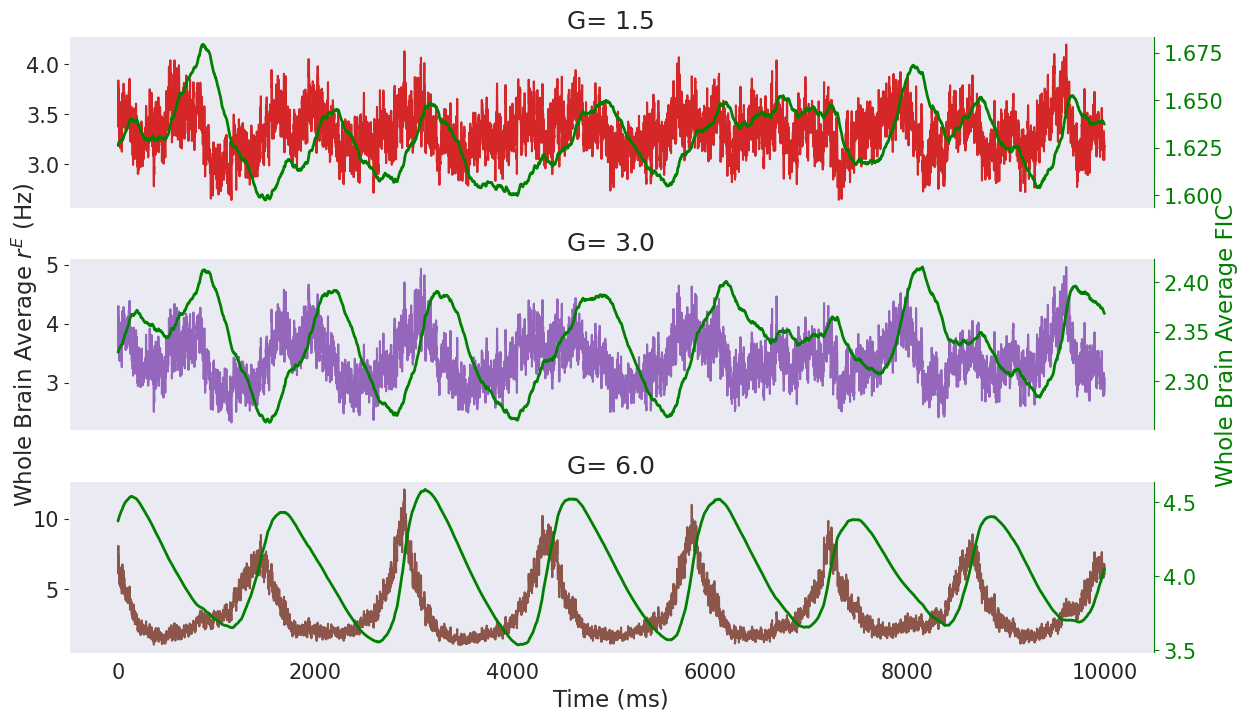

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Font sizes
TITLE = 18
LABEL = 16.5
TICKS = 15
LEGEND = 12

# Parameters
max_t = 10000
acor_tbase = np.arange(0, max_t)
figname = 'FIG_5'
sns.set_style("dark")
col_pal = sns.color_palette()

# Create the figure with improved spacing
fig, axes = plt.subplots(3, 1, figsize=(14, 8), gridspec_kw={'hspace': 0.3})

for e in range(3):
    ax = axes[e]
    ax.plot(acor_tbase, np.mean(e_rates_tseries[e, :, :max_t], axis=0), color=col_pal[3 + e])

    # Create a twin Axes for the right y-axis
    ax2 = ax.twinx()
    ax2.plot(acor_tbase, np.mean(fic_tseries[e, :, :max_t], axis=0), color='green', linewidth=2)

    # Labels and Titles
    if e==1:
        ax.set_ylabel(r'Whole Brain Average $r^E$ (Hz)', fontsize=LABEL)
        ax2.set_ylabel(r'Whole Brain Average FIC', fontsize=LABEL, color='green')

    ax.set_title(f'G= {gvals_tseries[e]}', fontsize=TITLE)

    # Customize the right y-axis ticks and line color
    ax2.yaxis.set_tick_params(color='green', labelcolor='green', labelsize=TICKS)
    ax2.spines['right'].set_color('green')

    # Hide x-axis ticks for the first two plots
    if e == 2:
        ax.set_xlabel('Time (ms)', fontsize=LABEL)
    else:
        ax.set_xticks([])

    # Axes properties
    ax.tick_params(axis='both', labelsize=TICKS)
    ax2.tick_params(axis='y', labelsize=TICKS)
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(e == 2)  # Bottom spine visible only for the last plot

#plt.tight_layout()

# Save the figure
#fig.savefig(figfold + figname + '_A.png', dpi=300)
#fig.savefig(figfold + figname + '_A.svg', dpi=300)
plt.show()


In [26]:

sns.set(style="darkgrid")

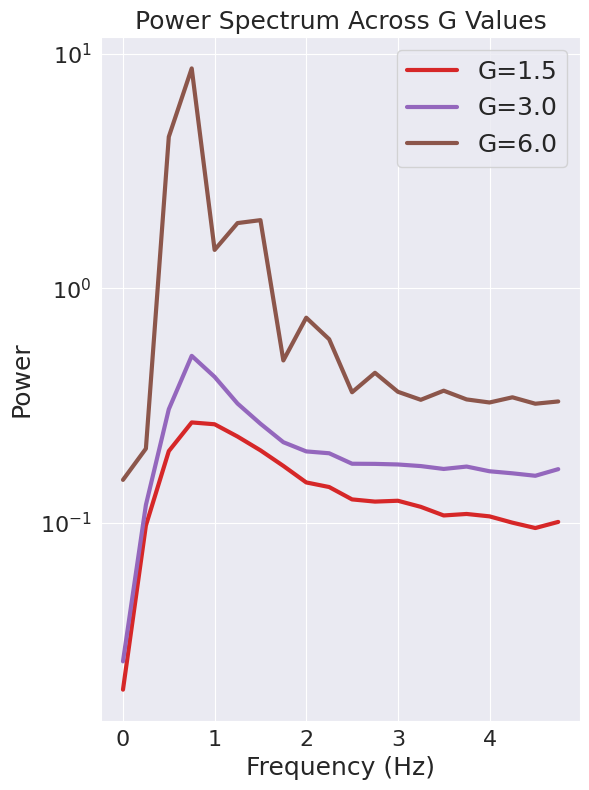

In [64]:
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 18
TICKS = 16
LEGEND = 18



# Parameters
figname = 'FIG_5_B'
sns.set_style("darkgrid")
# Create the figure
fig, ax = plt.subplots(figsize=(6, 8))

# Plot power spectra for different G values using semilogy
for i in range(3):
    freq, power, f, p = get_max_freq_and_power(e_rates_tseries[i])
    ax.semilogy(f[:20], (p[:, :20].T).mean(axis=1),
                label=f'G={gvals_tseries[i]}',
                color=col_pal[3 + i], linewidth=3)

# Labels, title, and ticks
ax.set_xlabel('Frequency (Hz)', fontsize=LABEL)
ax.set_ylabel('Power', fontsize=LABEL)
ax.set_title('Power Spectrum Across G Values', fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)

# Add legend
ax.legend(fontsize=LEGEND)

# Layout and save
plt.tight_layout()
fig.savefig(figfold + figname + '.png', dpi=300)
fig.savefig(figfold + figname + '.svg', dpi=300)
plt.show()


In [ ]:
results_folder = './Results/slow_waves'
max_freq_grid = np.load(os.path.join(results_folder, 'max_freq_grid.npy'))
max_power_grid = np.load(os.path.join(results_folder, 'max_power_grid.npy'))
mean_max_freq = max_freq_grid.mean(axis=0).T
mean_max_power = max_power_grid.mean(axis=0).T

In [11]:
max_freq_grid.shape

(8, 60, 100)

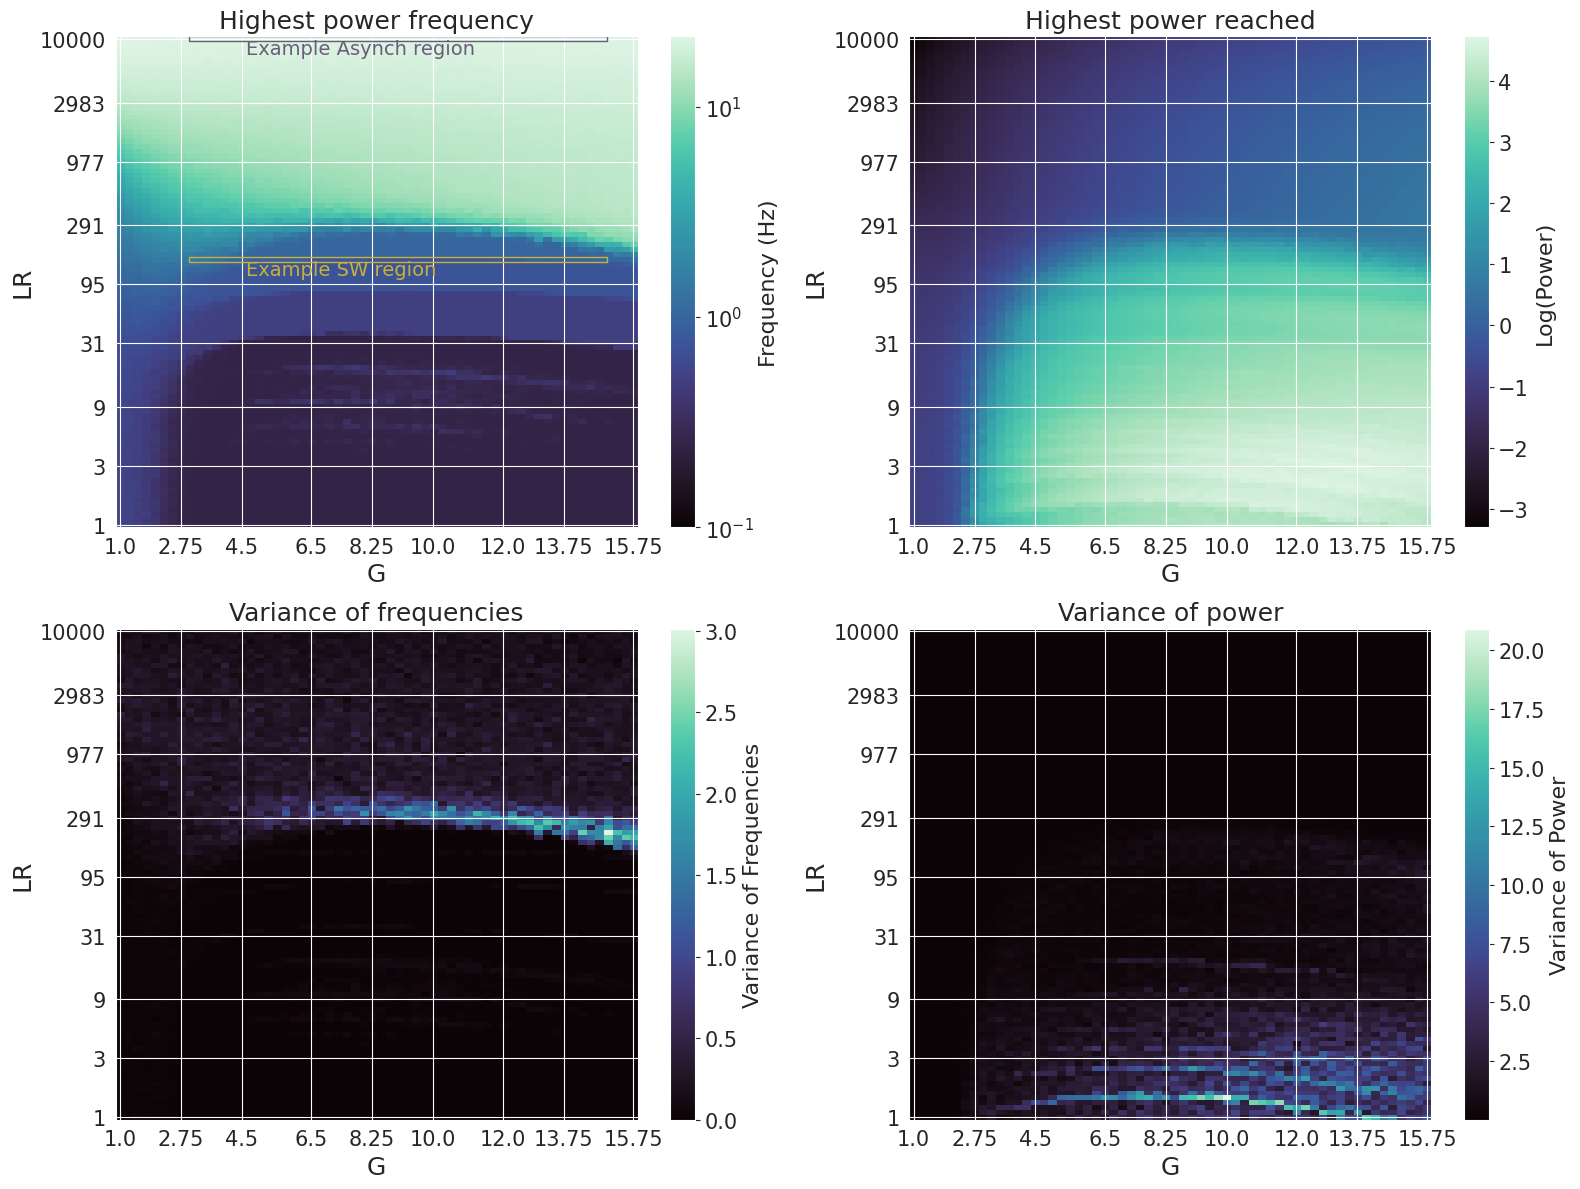

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
TICKS = 15
LABEL = 18
COLORBAR = 16

figname_base = 'FIG_5_'

# FIG_2_A: Heatmap for max_freq_grid (Log Normalization)
im1 = axs[0, 0].imshow(mean_max_freq, aspect='auto', cmap='mako',
                       norm=LogNorm(vmin=0.1, vmax=mean_max_freq.max()),
                       origin='upper')
cbar1 = fig.colorbar(im1, ax=axs[0, 0])
cbar1.minorticks_off()
cbar1.set_label('Frequency (Hz)', fontsize=COLORBAR)
cbar1.ax.tick_params(labelsize=TICKS)

# Define G nd LR ranges
G_max = 16
G_step = 0.25
G_range = np.arange(1, G_max, G_step)
LR_range = np.logspace(0, 4, 100)

# Define tick indices and labels
lr_tick_indices = np.linspace(0, len(LR_range) - 1, 9, dtype=int)
lr_tick_labels = np.round(LR_range[lr_tick_indices], 2)
G_tick_indices = np.linspace(0, len(G_range) - 1, 9, dtype=int)
G_tick_labels = np.round(G_range[G_tick_indices], 2)

col_pal_sw_asynch = ['#C9B037','#6C5B7B']

# Add fine red lines and annotations
G_3_idx = np.argmin(np.abs(G_range - 3))
G_16_idx = np.argmin(np.abs(G_range - 15))
lr_100_idx = np.argmin(np.abs(LR_range - 150))
# draw a rectangle spanning G_3_idx→G_16_idx at the LR index
rect = Rectangle(
    (G_3_idx, lr_100_idx - 0.5),          # lower-left corner
    G_16_idx - G_3_idx,                   # width
    1,                                     # height = 1 cell
    linewidth=1,
    edgecolor=col_pal_sw_asynch[0],
    facecolor='none'
)
axs[0, 0].add_patch(rect)
axs[0, 0].text(14.5, lr_100_idx, 'Example SW region', color=col_pal_sw_asynch[0], fontsize=LABEL-4, verticalalignment='top')
lr_1000_idx = np.argmin(np.abs(LR_range - 10150))
# draw a rectangle spanning G_3_idx→G_16_idx at the LR index
rect_asynch = Rectangle(
    (G_3_idx, lr_1000_idx - 0.5),          # lower-left corner
    G_16_idx - G_3_idx,                   # width       
    1,                                     # height = 1 cell
    linewidth=1,
    edgecolor=col_pal_sw_asynch[1],
    facecolor='none'
)
axs[0, 0].add_patch(rect_asynch)
axs[0, 0].text(14.5, lr_1000_idx, 'Example Asynch region', color=col_pal_sw_asynch[1], fontsize=LABEL-4, verticalalignment='top')

# Tick settings
axs[0, 0].set_xticks(G_tick_indices)
axs[0, 0].set_xticklabels(G_tick_labels, fontsize=TICKS)
axs[0, 0].set_yticks(lr_tick_indices)
axs[0, 0].set_yticklabels([int(label) for label in lr_tick_labels], fontsize=TICKS)
axs[0, 0].invert_yaxis()

# Labels and Title
axs[0, 0].set_xlabel('G', fontsize=LABEL)
axs[0, 0].set_ylabel('LR', fontsize=LABEL)
axs[0, 0].set_title('Highest power frequency', fontsize=TITLE)

# FIG_2_B: Heatmap for max_power_grid (Normal Display with log scale)
im2 = axs[0, 1].imshow(np.log(mean_max_power), aspect='auto', cmap='mako', origin='upper')
cbar2 = fig.colorbar(im2, ax=axs[0, 1])
cbar2.set_label('Log(Power)', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)

# Tick settings
axs[0, 1].set_xticks(G_tick_indices)
axs[0, 1].set_xticklabels(G_tick_labels, fontsize=TICKS)
axs[0, 1].set_yticks(lr_tick_indices)
axs[0, 1].set_yticklabels([int(label) for label in lr_tick_labels], fontsize=TICKS)
axs[0, 1].invert_yaxis()

# Labels and Title
axs[0, 1].set_xlabel('G', fontsize=LABEL)
axs[0, 1].set_ylabel('LR', fontsize=LABEL)
axs[0, 1].set_title('Highest power reached', fontsize=TITLE)

# Compute std values
std_max_freq = max_freq_grid.std(axis=0).T
std_max_power = max_power_grid.std(axis=0).T

# FIG_2_C: Heatmap for std_max_freq
im3 = axs[1, 0].imshow(std_max_freq, aspect='auto', cmap='mako', origin='upper')
cbar3 = fig.colorbar(im3, ax=axs[1, 0])
cbar3.set_label('Variance of Frequencies', fontsize=COLORBAR)
cbar3.ax.tick_params(labelsize=TICKS)

# Tick settings
axs[1, 0].set_xticks(G_tick_indices)
axs[1, 0].set_xticklabels(G_tick_labels, fontsize=TICKS)
axs[1, 0].set_yticks(lr_tick_indices)
axs[1, 0].set_yticklabels([int(label) for label in lr_tick_labels], fontsize=TICKS)
axs[1, 0].invert_yaxis()

# Labels and Title
axs[1, 0].set_xlabel('G', fontsize=LABEL)
axs[1, 0].set_ylabel('LR', fontsize=LABEL)
axs[1, 0].set_title('Variance of frequencies', fontsize=TITLE)

# FIG_2_D: Heatmap for std_max_power
im4 = axs[1, 1].imshow(std_max_power, aspect='auto', cmap='mako', origin='upper')
cbar4 = fig.colorbar(im4, ax=axs[1, 1])
cbar4.set_label('Variance of Power', fontsize=COLORBAR)
cbar4.ax.tick_params(labelsize=TICKS)

# Tick settings
axs[1, 1].set_xticks(G_tick_indices)
axs[1, 1].set_xticklabels(G_tick_labels, fontsize=TICKS)
axs[1, 1].set_yticks(lr_tick_indices)
axs[1, 1].set_yticklabels([int(label) for label in lr_tick_labels], fontsize=TICKS)
axs[1, 1].invert_yaxis()

# Labels and Title
axs[1, 1].set_xlabel('G', fontsize=LABEL)
axs[1, 1].set_ylabel('LR', fontsize=LABEL)
axs[1, 1].set_title('Variance of power', fontsize=TITLE)

plt.tight_layout()
#plt.savefig(figfold + figname_base + 'Combined.png', dpi=300)
#plt.savefig(figfold + figname_base + 'Combined.svg', dpi=300)
plt.show()


# Fig 6 - Chimeras

In [2]:
# Load the data
e_rates_dyn_list = np.load(datafolder + 'chimeras/example_rates.npy', allow_pickle=True)
# load rates_all_low_lr and rates_all_high_lr
rates_all_low_lr = np.load(f"{datafolder}chimeras/homogeneous/rates_all_low_lr.npy")
rates_all_high_lr = np.load(f"{datafolder}chimeras/homogeneous/rates_all_high_lr.npy")

/tmp/ipykernel_411958/2412993916.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


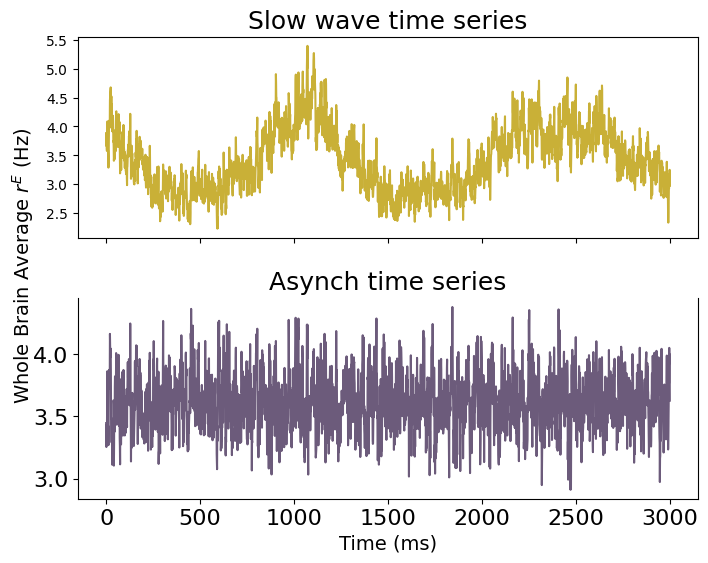

In [3]:

# Font sizes (using notebook variables)
TITLE = 18
LABEL = 14
TICKS = 16
LEGEND = 16

max_t = 3000
acor_tbase = np.arange(0, max_t)
figname = 'FIG_6_A'
col_pal_sw_asynch = ['#C9B037','#6C5B7B']
START = 0
# Create the figure with two subplots (for LR=100 and LR=10000) at G=0.5
fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'hspace': 0.3})


ax = axes[0]
# Plot the average excitatory rate for the i-th dyn time series sample
ax.plot(acor_tbase, np.mean(e_rates_dyn_list[0, :, START:START+max_t], axis=0), color=col_pal_sw_asynch[0])

# Set title with the corresponding LR value and fixed G=0.5
ax.set_title(f'Slow wave time series', fontsize=TITLE)
#ax.set_xticks([])
ax.set_xticklabels([])
ax = axes[1]
ax.plot(acor_tbase, np.mean(e_rates_dyn_list[1, :, START:START+max_t], axis=0), color=col_pal_sw_asynch[1])
ax.set_title(f'Asynch time series', fontsize=TITLE)
ax.set_xlabel('Time (ms)', fontsize=LABEL)
# Hide the top spine
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', labelsize=TICKS)

# Add a shared ylabel in the middle of both subplots
fig.text(0.04, 0.5, r'Whole Brain Average $r^E$ (Hz)', va='center', rotation='vertical', fontsize=LABEL)
plt.tight_layout()
# Save the figure
#fig.savefig(figfold + figname + '.png', dpi=300)
#fig.savefig(figfold + figname + '.svg', dpi=300)
plt.show()


In [4]:
# High LR
def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

results_high_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_high_lr)
max_freqs_all_high_lr, max_powers_all_high_lr, freqs_all_high_lr, psd_all_high_lr = zip(*results_high_lr)
max_freqs_all_high_lr = np.array(max_freqs_all_high_lr)
max_powers_all_high_lr = np.array(max_powers_all_high_lr)
freqs_all_high_lr = np.array(freqs_all_high_lr)
psd_all_high_lr = np.array(psd_all_high_lr)

# Low LR
results_low_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_low_lr)
max_freqs_all_low_lr, max_powers_all_low_lr, freqs_all_low_lr, psd_all_low_lr = zip(*results_low_lr)
max_freqs_all_low_lr = np.array(max_freqs_all_low_lr)
max_powers_all_low_lr = np.array(max_powers_all_low_lr)
freqs_all_low_lr = np.array(freqs_all_low_lr)
psd_all_low_lr = np.array(psd_all_low_lr)

In [5]:
from bct import score_wu, rich_club_wu
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
# Select the nodes with the hihgest node strength from SC matrix C
C = 0.2*C/np.max(C)
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]

score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 

Loading quimeric deltas
Significant difference for 13 regions: p-value = 0.0139
Significant difference for 78 regions: p-value = 0.0000
Significant difference for 102 regions: p-value = 0.0000
Significant difference for 134 regions: p-value = 0.0034
Significant difference for 152 regions: p-value = 0.0084


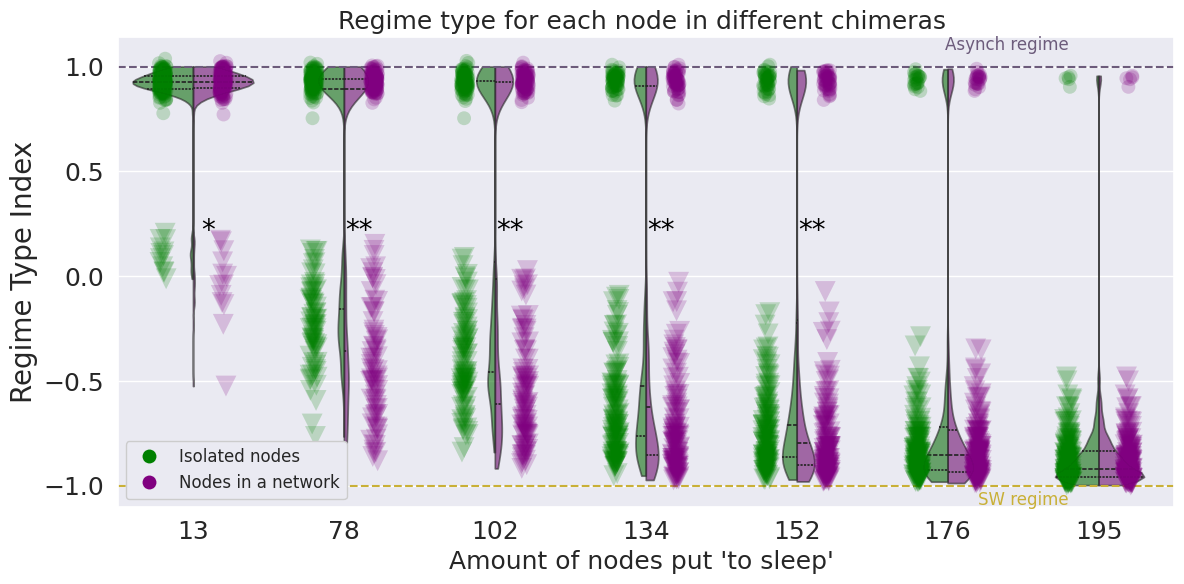

In [6]:
from matplotlib import markers
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = False

sns.set(style="darkgrid")

# Font sizes
TITLE = 18
LABEL = 18
TICKS = 18
LEGEND = 18


G_VAL = 3.5
LR_HOMO = 10000
LR_HET = 100
N = C.shape[0]
# Load the previously saved data
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]
print("Loading quimeric deltas")
quimeric_delta = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy")
quimeric_delta_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy")
max_freqs_all_het = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy")
max_freqs_all_het_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy")
max_powers_all_het = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy")
max_powers_all_het_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy")


# Parameters
figname = 'FIG_6_C'
# 1) Build the actual selections for each amount
str_selections   = [most_connected[:N]        for N in amount_of_regions]
score_selections = [score_idxs[idx]           for idx in cherry_pick_scores_idx]
# 2) Turn them into Boolean masks of shape (n_amounts, n_regions)
str_mask   = np.array([[r in sel for r in range(N)] for sel in str_selections])
score_mask = np.array([[r in sel for r in range(N)] for sel in score_selections])
# 3) Flatten everything into one long vector
values        = np.concatenate([quimeric_delta.ravel(),        quimeric_delta_score.ravel()])
groups        = ['STR']   * quimeric_delta.size + ['S-CORE'] * quimeric_delta_score.size
amounts       = np.concatenate([
                    np.repeat(amount_of_regions, N),
                    np.repeat(amount_of_regions, N)
               ])
selected_flag = np.concatenate([str_mask.ravel(), score_mask.ravel()])


# 4) Build the DataFrame
data = pd.DataFrame({
    'value'             : values,
    'group'             : groups,
    'amount_of_regions' : amounts,
    'selected'          : selected_flag
})
# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Add dashed lines
ax.axhline(y=1, color=col_pal_sw_asynch[1], linestyle='--')
ax.text(5.8, 1.08, 'Asynch regime', color=col_pal_sw_asynch[1], fontsize=12, ha='right')

ax.axhline(y=-1, color=col_pal_sw_asynch[0], linestyle='--')
ax.text(5.8, -1.09, 'SW regime', color=col_pal_sw_asynch[0], fontsize=12, ha='right')

# Strip plot for all those that were not selected

data_non = data[data['selected'] == False]  # Filter out selected regions
# Strip plot
sns.stripplot(data=data_non, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, marker='o',linewidth=0,edgecolor=None,
              palette=['green', 'purple'], s=10, alpha=0.2)
# Stripplot on top of the same axes for selected regions
data_sel = data[data['selected'] == True]  # Filter out selected regions
# Strip plot for selected regions
sns.stripplot(data=data_sel, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, marker='v', linewidth=0,edgecolor=None,
              palette=['green', 'purple'], s=15, alpha=0.2)
strip_handles, strip_labels = ax.get_legend_handles_labels()
for h in strip_handles:
    h.set_alpha(1.0)

# Add a 'v' marker to the strip handle without any color
# add a red 'v' marker for the "Selected regions" legend entry
selected_handle = Line2D([0], [0],
                         marker='v',
                         markerfacecolor='grey',     
                         markeredgecolor='None',                    
                         linestyle='None',
                         markersize=10)

non_selected_handle = Line2D([0], [0],
                         marker='o',
                         markerfacecolor='grey',                         
                            markeredgecolor='None',
                         linestyle='None',
                         markersize=10)

selected_handles = [selected_handle, non_selected_handle]
selected_labels = ["Nodes put 'to sleep'", "Nodes 'awake'"]


# Violin plot
# Clip the data from 1 to -1
data['value'] = np.clip(data['value'], -1, 1)
sns.violinplot(data=data, x='amount_of_regions', y='value', hue='group', ax=ax, 
               palette=['green', 'purple'], split=True, inner='quartile', bw_method=0.1,cut=0, alpha=0.6)

# Statistical tests: compare STR and S-CORE per amount_of_regions.
unique_amounts = sorted(data['amount_of_regions'].unique())

for idx_amt,amt in enumerate(unique_amounts):
    subset = data[data['amount_of_regions'] == amt]
    values_str = subset[subset['group'] == 'STR']
    values_score = subset[subset['group'] == 'S-CORE']
    values_str = values_str[values_str['selected']]['value']
    values_score = values_score[values_score['selected']]['value']
    stat, p_val = ttest_ind(values_str, values_score)
    if p_val < 0.05:
        print(f"Significant difference for {amt} regions: p-value = {p_val:.4f}")
        y_max = subset['value'].max()
        # Annotate star above the max value with a small offset
        ax.text(0.1+idx_amt, 0.15, '**' if p_val<0.01 else '*' , ha='center', va='bottom', color='black', fontsize=20)

# Labels, title, and legend
ax.set_xlabel("Amount of nodes put 'to sleep' ", fontsize=LABEL)
ax.set_ylabel("Regime Type Index", fontsize=LABEL+2)
ax.set_title("Regime type for each node in different chimeras ", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.set_yticks([1, 0.5, 0, -0.5, -1])
# First legend: isolated vs network nodes
first_legend = ax.legend(
    strip_handles,
    ["Isolated nodes", "Nodes in a network"],
    fontsize=12,
    title_fontsize=14,
    loc='lower left',
    framealpha=1
)

# Layout and save
plt.tight_layout()
#fig.savefig(os.path.join(figfold, figname + '.svg'), dpi=300)
#fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
plt.show()



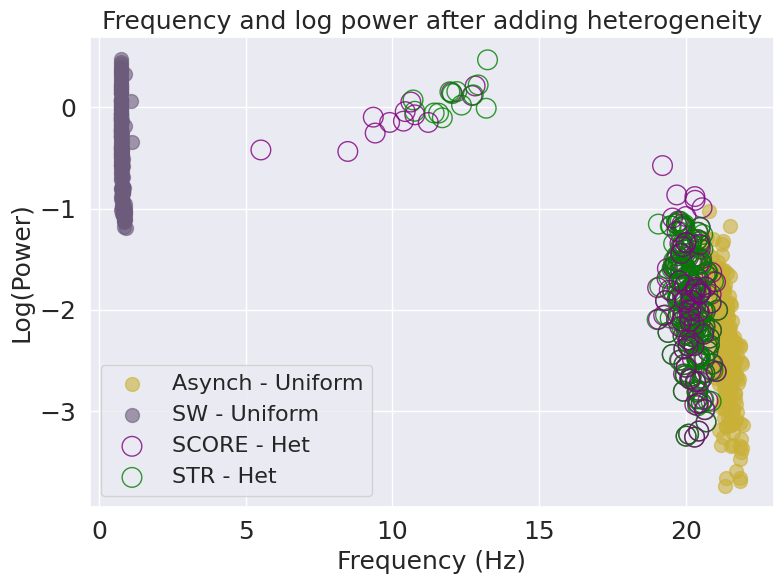

In [7]:
from turtle import color
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 18
TICKS = 18
LEGEND = 16

# Parameters
figname = 'FIG_6_B'

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots for high and low learning rates
ax.scatter(max_freqs_all_high_lr.mean(axis=0), np.log(max_powers_all_high_lr.mean(axis=0)), label="Asynch - Uniform", alpha=0.6, s=100,color=col_pal_sw_asynch[0])
ax.scatter(max_freqs_all_low_lr.mean(axis=0), np.log(max_powers_all_low_lr.mean(axis=0)), label="SW - Uniform", alpha=0.6, s=100,color=col_pal_sw_asynch[1])
split_idx = max_freqs_all_het.shape[-1] // 2
plt.scatter(max_freqs_all_het_score[0].mean(axis=0)[:split_idx+50], np.log(max_powers_all_het_score[0].mean(axis=0))[:split_idx+50], label="SCORE - Het", alpha=0.8, s=200, color='purple',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het[0].mean(axis=0)[:split_idx], np.log(max_powers_all_het[0].mean(axis=0))[:split_idx], label="STR - Het", alpha=0.8, s=200, color='green',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het[0].mean(axis=0)[split_idx:], np.log(max_powers_all_het[0].mean(axis=0))[split_idx:], label=None, alpha=0.8, s=200, color='green',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het_score[0].mean(axis=0)[split_idx+50:], np.log(max_powers_all_het_score[0].mean(axis=0))[split_idx+50:], label=None, alpha=0.8, s=200, color='purple',facecolors='none',zorder=2)

# Labels, title, and legend
ax.set_xlabel("Frequency (Hz)", fontsize=LABEL)
ax.set_ylabel("Log(Power)", fontsize=LABEL)
ax.set_title("Frequency and log power after adding heterogeneity", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(fontsize=LEGEND)

# Layout and save
plt.tight_layout()
#fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
#fig.savefig(figfold + figname + '.svg', dpi=300)
plt.show()


Loading quimeric deltas


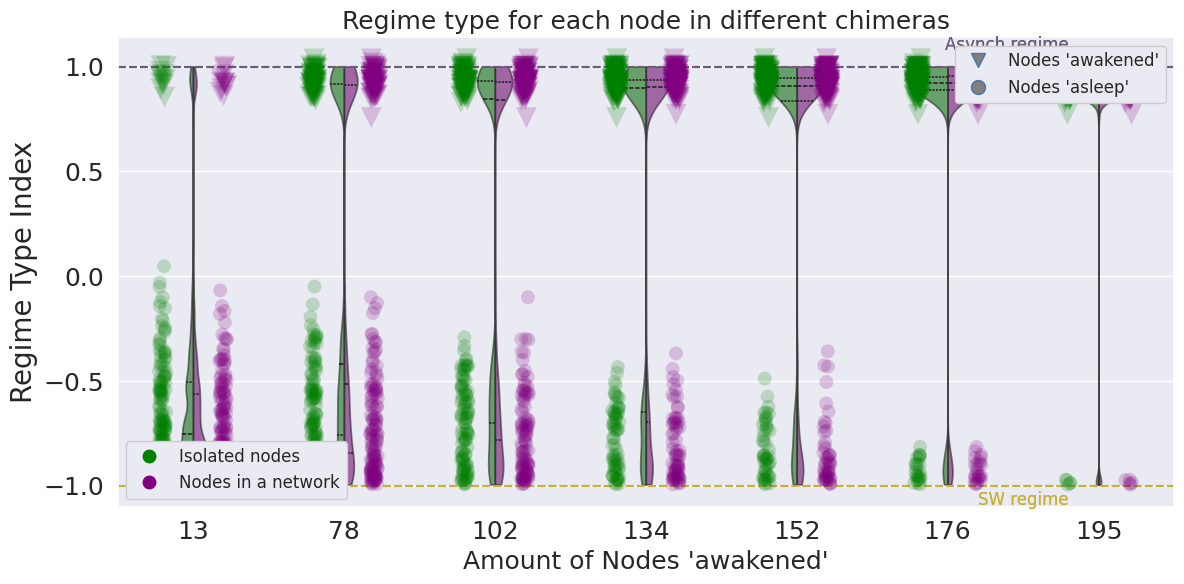

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


G_VAL = 3.5
LR_HOMO = 100
LR_HET = 10000
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]

# Load the previously saved data
print("Loading quimeric deltas")
quimeric_delta = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy")
quimeric_delta_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy")
max_freqs_all_het = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy")
max_freqs_all_het_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy")
max_powers_all_het = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy")
max_powers_all_het_score = np.load(f"{datafolder}chimeras/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy")


# Font sizes

TITLE = 18
LABEL = 18
TICKS = 18
LEGEND = 18

# Parameters
figname = 'FIG_6_D'
str_selections   = [most_connected[:N]        for N in amount_of_regions]
score_selections = [score_idxs[idx]           for idx in cherry_pick_scores_idx]
# 2) Turn them into Boolean masks of shape (n_amounts, n_regions)
str_mask   = np.array([[r in sel for r in range(N)] for sel in str_selections])
score_mask = np.array([[r in sel for r in range(N)] for sel in score_selections])
# 3) Flatten everything into one long vector
values        = np.concatenate([quimeric_delta.ravel(),        quimeric_delta_score.ravel()])
groups        = ['STR']   * quimeric_delta.size + ['S-CORE'] * quimeric_delta_score.size
amounts       = np.concatenate([
                    np.repeat(amount_of_regions, N),
                    np.repeat(amount_of_regions, N)
               ])
selected_flag = np.concatenate([str_mask.ravel(), score_mask.ravel()])


# 4) Build the DataFrame
data = pd.DataFrame({
    'value'             : values,
    'group'             : groups,
    'amount_of_regions' : amounts,
    'selected'          : selected_flag
})
# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Add dashed lines
ax.axhline(y=1, color=col_pal_sw_asynch[1], linestyle='--')
ax.text(5.8, 1.08, 'Asynch regime', color=col_pal_sw_asynch[1], fontsize=12, ha='right')

ax.axhline(y=-1, color=col_pal_sw_asynch[0], linestyle='--')
ax.text(5.8, -1.09, 'SW regime', color=col_pal_sw_asynch[0], fontsize=12, ha='right')

# Strip plot for all those that were not selected

data_non = data[data['selected'] == False]  # Filter out selected regions
# Strip plot
sns.stripplot(data=data_non, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, marker='o',
              palette=['green', 'purple'], s=10, alpha=0.2)
# Stripplot on top of the same axes for selected regions
data_sel = data[data['selected'] == True]  # Filter out selected regions
# Strip plot for selected regions
sns.stripplot(data=data_sel, x='amount_of_regions', 
              y='value', hue='group', jitter=0.05, dodge=True, ax=ax, marker='v',
              palette=['green', 'purple'], s=15, alpha=0.2)
strip_handles, strip_labels = ax.get_legend_handles_labels()
for h in strip_handles:
    h.set_alpha(1.0)

# Add a 'v' marker to the strip handle without any color
# add a red 'v' marker for the "Selected regions" legend entry
selected_handle = Line2D([0], [0],
                         marker='v',
                         markerfacecolor='grey',                         
                         linestyle='None',
                         markersize=10)

non_selected_handle = Line2D([0], [0],
                         marker='o',
                         markerfacecolor='grey',                         
                         linestyle='None',
                         markersize=10)

selected_handles = [selected_handle, non_selected_handle]
selected_labels = ["Nodes 'awakened'", "Nodes 'asleep'"]

# Violin plot with the same settings as before
# Clip the data from 1 to -1
data['value'] = np.clip(data['value'], -1, 1)
sns.violinplot(data=data, x='amount_of_regions', y='value', hue='group', ax=ax, 
               palette=['green', 'purple'], split=True, inner='quartile', bw_method=0.1, cut=0, alpha=0.6)

# Add dashed lines using the same style as in the previous panel
ax.axhline(y=1, color=col_pal_sw_asynch[1], linestyle='--')
ax.text(5.8, 1.08, 'Asynch regime', color=col_pal_sw_asynch[1], fontsize=12, ha='right')

ax.axhline(y=-1, color=col_pal_sw_asynch[0], linestyle='--')
ax.text(5.8, -1.09, 'SW regime', color=col_pal_sw_asynch[0], fontsize=12, ha='right')

# Labels, title, and legend
ax.set_xlabel("Amount of Nodes 'awakened'", fontsize=LABEL)
ax.set_ylabel("Regime Type Index", fontsize=LABEL+2)
ax.set_title("Regime type for each node in different chimeras", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.set_yticks([1, 0.5, 0, -0.5, -1])
# Manually set the legend box position
# First legend: isolated vs network nodes
first_legend = ax.legend(
    strip_handles,
    ["Isolated nodes", "Nodes in a network"],
    fontsize=12,
    title_fontsize=14,
    loc='lower left',
    framealpha=1
)
# keep the first legend on the axes
ax.add_artist(first_legend)

# Second legend: selected vs non-selected regions
ax.legend(
    selected_handles,
    selected_labels,
    fontsize=12,
    title_fontsize=14,
    loc='upper right',
    framealpha=1
)
# Layout and save
plt.tight_layout()
#fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
#fig.savefig(os.path.join(figfold, figname + '.svg'), dpi=300)
plt.show()
